# Estimating the effect of adjuvant chemotherapy in stage III colon cancer

Analysis of colon cancer data from Felice's PhD thesis.

**Inclusion criteria were:**    
* pTNM III (pT<sub>1-4</sub>N<sub>1-2</sub>M<sub>0</sub>) colon carcinoma
* age ≥ 70
* Diagnosis between **2005** and **2012**; follow-up for recurrence was in **2013** and **2014**.
* Treatment with:
    * Surgical resection
    * Surgical resection followed by adjuvant capecetabine + oxaliplatin
    * Surgical resection followed by adjuvant capecetabine only

This notebook runs the analyses from A-Z: 
* Loads the (CSV) dataset created by Felice. 
* Filters patients that ..
    * Died within 90 days of surgery
    * Have missing follow-up data

In [1]:
# Mark this cell to receive output later
summary_cell = display(display_id=True)
notebook_summary = []

## Summary of files created
Below you'll find a list of files that were created/written while running this notebook.
The cell that creates/displays this summary, can be found <a href="#Finish">here</a>.
## Summary of files created
Below you'll find a list of files that were created/written while running this notebook.
The cell that creates/displays this summary, can be found <a href="#Finish">here</a>.
### All variables
**All records**
* data_processed/pickle/colonca_2005-2012_full.pickle

**Patients with adjuvant treatment only**
* data_processed/pickle/colonca_2005-2012_adjuvant_only.pickle

### Simplified datasets
**All records**
* data_processed/colonca_2005-2012_simplified.csv
* data_processed/pickle/colonca_2005-2012_simplified.pickle

**Adjuvant vs None dataset**
* data_processed/colonca_2005-2012_adjuvant-none.csv
* data_processed/pickle/colonca_2005-2012_adjuvant-none.pickle

**Adjuvant only dataset**
* data_processed/colonca_2005-2012_CAPOX-CapMono.csv
* data_processed/pickle/colonca_2005-2012_CAPOX-CapMono.pickle

### Constraints for BN
* data_processed/generated_constraints_BL.net
* data_processed/generated_constraints_mWL.net
* results/structure learning constraints.xlsx

# Preamble

In [2]:
%run '_preamble.ipynb'

from altair_saver import save

import rpy2
rpy2.rinterface_lib.callbacks.consolewrite_warnerror = lambda *args: None

# Cochran-Mantel-Haensel Chi2 test.
from cmh import CMH

from data_science_tools.base import filter_dict_by_keys
from thomas.core.reader import oobn

from util import (
    population_from_covariables, 
    CoxItUp, 
    get_HR_details,
    predict_survival_from_CPH,
    plot_prediction,
    chart_with_markers,
)

import colon_support as support
from util import compute_propensity_scores


Python version: 3.8.14
NumPy version: 1.20.3
Pandas version: 1.3.2


/Users/melle/.virtualenvs/giordano/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


This script was last run on Friday, 17-03-2023, 16:12

Current working directory: "/Users/melle/IKNL/04 - Projecten/Observational data for CER (internship)/src/giordano-melle/colon-analysis"

connect to this kernel with:
  jupyter console --existing aefa2e7f-0673-4c9b-8f67-3ea2f55efd94



In [3]:
INPUT_PATH = os.path.join(
    'data',
)

DATA_PATH = os.path.join(
    'data_processed',
)

RESULTS_PATH = os.path.join(
    'results',
)


# Data preparation

## Load Kern

Primary inclusion criteria already applied in SAS (by Felice).


In [4]:
# filename = os.path.join(INPUT_PATH, 'setruby090720_leveren.csv')
filename = os.path.join(INPUT_PATH, 'setruby090720_leveren_updated.csv')

df = support.load_dataset(filename)
print(f'The dataset contains {df.shape[0]} records')

The dataset contains 1156 records


In [5]:
# Initialize the data pyramid
pyramid = tools.pyramid.Pyramid()
pyramid.update("Initial dataset", df)

## Drop NAs in post-surgery follow-up
We can't determine survival if follow-up after surgery is unavailable.

In [6]:
df = df[~df.surv_months_post_surg.isna()]
pyramid.update("Dropping NAs in surv_months_post_surg", df)

## Drop NAs in `adj_therapy_type`
Adjuvant therapy type can be None, CAPOX or CapMono. We need this to determine treatment given.

In [7]:
df = df[~df.adj_therapy_type.isna()]
pyramid.update("Dropping NAs in adj_therapy_type", df)

## Drop those who died within 90d of surgery
These may be considered complications. Also, these patients would never have received chemotherapy, so including them would result in an unfair comparison.

In [8]:
df = df[df.died_within_90d_of_surg == 0]
pyramid.update("Those who died within 90 days of surgery", df)

## Discretize age
We'll discretize age into the following categories:
* 70 - 74
* 75 - 79
* ≥ 80

In [9]:
age = pd.cut(
    df.age_cont, 
    bins=[70, 75, 80, df.age_cont.max() + 1], 
    labels=['70 - 74', '75 - 79', '80+'],
    right=False
)
age.name = 'age'
df['age'] = age

# Sanity check
df[['age', 'age_cont']].value_counts(sort=False).head(8)

age      age_cont
70 - 74  70          48
         71          59
         72          70
         73          65
         74          58
75 - 79  75          69
         76          59
         77          76
dtype: int64

## Binning year of diagnosis
Two ways to discretise year of diagnosis:
* by TNM edition
    * TNM 5: 1999 - 2002
    * <b>TNM 6: 2003 - 2009</b>
    * <b>TNM 7: 2010 - 2016</b>
* by 5-year intervals


In [10]:
df['yod_cat'] = pd.cut(
    df.yod, 
    bins=[2004, 2007, 2010, 2012], 
    labels=['2005-2007', '2008-2010', '2011-2012'],
    right=True
)

df[['yod_cat', 'yod']].value_counts(sort=False)

yod_cat    yod 
2005-2007  2005     90
           2006    111
           2007    114
2008-2010  2008    128
           2009    125
           2010    137
2011-2012  2011    130
           2012    147
dtype: int64

## Discretize survival
Discretization may introduce NAs if patient was alive at last follow-up but follow-up was less than a cutoff (say 5 years). In this case, we should have ≥ 5 year follow-up for all patients.

In [11]:
labels_surv = tools.surv.discretize_survival(
    df, 
    event_col = 'deceased',
    time_col = 'surv_days_post_surg',
    multiplier = 365,
    inplace = True,
)
    
count_missing_values = df[labels_surv].isna().sum().sum()
print(f"Nr. of missing values in discrete survival columns: {count_missing_values}")
print()

df[labels_surv].head()

Nr. of missing values in discrete survival columns: 78



surv_01y surv_02y surv_03y surv_04y surv_05y
key_id                                                
100107202    False    False    False    False    False
100142724    False    False    False    False    False
100259186     True    False    False    False    False
100284915     True     True     True     True     True
100495420     True     True     True     True    False

## Discretize *recurrence*
We're discretizing recurrence, not recurrence-free survival. The column `rfs_event` counts both recurrence and death as events. Since we'd like to predict survival based on recurrence, it wouldn't make sense to include 'death' as a predictor of itself.

This leads to a little bit of difficulty: there's no variable to indicate the time to recurrence _only_; the variables `RFS_months_post_surg` and `RFS_months_post_chemo` may indicate _either_ recurrence or death. However, the variable `recurrence` may be used to to filter those.

In [12]:
labels_recfree = tools.surv.discretize_survival(
    df, 
    event_col = 'recurrence',
    time_col = 'RFS_months_post_surg',
    prefix = 'recfree_',
    multiplier = 12,
    inplace = True,
)

# head(df[labels_recfree])

# Initial analyses - Histograms and survival curves

## Follow-up OS

In [13]:
df.vitdat_updated_date.max()

Timestamp('2021-01-31 00:00:00')

In [14]:
df.surv_days_post_surg.median()

1767.0

In [15]:
df.surv_months_post_surg.median()

58.196721311475414

In [16]:
df[df.deceased == False].surv_months_post_surg.median()

112.85

In [17]:
df_fu = df[df.deceased == False].vitdat_updated_date.value_counts().reset_index()

In [18]:
c1 = alt.Chart(df_fu).mark_bar().encode(
    x = "index:T",
    y = 'vitdat_updated_date:Q'
)

c1.properties(
    height = 150
)

alt.Chart(...)

## Follow-up RFS

In [19]:
# df.head()

In [20]:
df[df.deceased == False].RFS_months_post_surg.median()

28.66

## 📊 💾 Tumor stage/grade

In [21]:
# Histogram of pT, pN, and grade.
c1 = alt.Chart(df, height=200, width=200).mark_bar().encode(
    alt.X("pT"),
    alt.Y("count()"),
    tooltip="count()",
)

c1 = c1 + c1.mark_text(dy=-5).encode(
    alt.Text("count()")
)

c2 = alt.Chart(df, height=200, width=100).mark_bar().encode(
    alt.X("pN"),
    alt.Y("count()"),
    tooltip="count()",
)

c2 = c2 + c2.mark_text(dy=-5).encode(
    alt.Text("count()")
)


c3 = alt.Chart(df, height=200, width=100).mark_bar().encode(
    alt.X("grade"),
    alt.Y("count()"),
    tooltip="count()",
)

c3 = c3 + c3.mark_text(dy=-5).encode(
    alt.Text("count()")
)


state_and_grade_chart = (c1 | c2 | c3)

filename = os.path.join(
    RESULTS_PATH, 
    'Figure - Variable distributions - stage and grade.pdf'
)

state_and_grade_chart.save(filename)
state_and_grade_chart

alt.HConcatChart(...)

In [22]:
base = alt.Chart(df, height=200, width=200).mark_square().encode(
    alt.X("pT:O"),
    alt.Y("pN:O"),
    alt.Size("count()"),
    tooltip=["pT", "pN", "count()"],
)

base + base.mark_text(dy=-20).encode(
    alt.Text("count()"),
    size = alt.value(12)
)


alt.LayerChart(...)

## 📊 Year of diagnosis & age

In [23]:
# Histogram of year of diagnosis
c1 = alt.Chart(df, height=200, width=200).mark_bar().encode(
    alt.X("yod"),
    alt.Y("count()"),
    tooltip="count()",
)

# Histogram of age
c2 = alt.Chart(df, height=200, width=200).mark_bar().encode(
    alt.X("age_cont:Q"),
    alt.Y("count()"),
    tooltip="count()",
)

c1 | c2

alt.HConcatChart(...)

<div class="alert alert-block alert-info">
    <p>Seems to be a rising trend in incidence. Could this be explained by start of screening in 2004?</p>
</div>

## 📈 💾 Survival & recurrence vs treatment

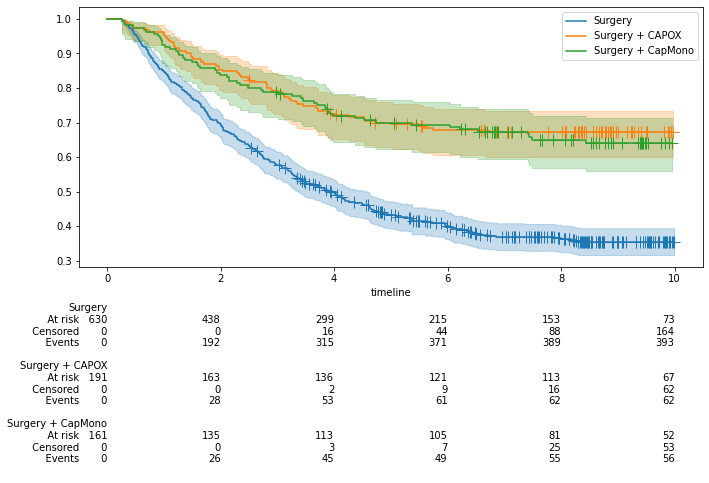

In [24]:
ix_none = df['treatment'] == 'Surgery'
ix_capox = df['treatment'] == 'Surgery + CAPOX'
ix_capmono = df['treatment'] == 'Surgery + CapMono'


fig, ax = plt.subplots(1, 1, figsize=(10, 7))

kmf_none = KaplanMeierFitter()
ax = kmf_none.fit(
    df.loc[ix_none]['surv_years_post_surg'], 
    df.loc[ix_none]['deceased'], 
    label='Surgery'
).plot_survival_function(
    show_censors = True,
    loc = slice(0, 10),
    ax = ax
)

kmf_capox = KaplanMeierFitter()
ax = kmf_capox.fit(
    df.loc[ix_capox]['surv_years_post_surg'], 
    df.loc[ix_capox]['deceased'], 
    label='Surgery + CAPOX'
).plot_survival_function(
    show_censors = True,
    loc = slice(0, 10),
    ax = ax
)

kmf_capmono = KaplanMeierFitter()
ax = kmf_capmono.fit(
    df.loc[ix_capmono]['surv_years_post_surg'], 
    df.loc[ix_capmono]['deceased'], 
    label='Surgery + CapMono'
).plot_survival_function(
    show_censors = True,
    loc = slice(0, 10),
    ax = ax
)


from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(kmf_none, kmf_capox, kmf_capmono, ax=ax)

filename = os.path.join(
    RESULTS_PATH, 
    'Figure - 10y survival - stratified by adjuvant treatment (matplotlib).pdf'
)

plt.tight_layout()
plt.savefig(filename)


In [25]:
# df.loc[df.deceased == False, ['surv_years_post_surg', 'deceased']].sort_values('surv_years_post_surg').head()

In [26]:
# df.loc[200103363]

In [27]:
km_surv = tools.plot.kaplan_meier(
    df[df.surv_years_post_surg.notna()], 
    'surv_years_post_surg', 
    'deceased', 
    split_by='treatment',
    x_title = 'Years',
    scale = alt.Scale(domain=(0, 10)),
    properties = {"width": 440, "height": 200},
).properties(
    title = "Overall Survival"
)

km_rec = tools.plot.kaplan_meier(
    df[df.surv_years_post_surg.notna()], 
    'RFS_months_post_surg', 
    'deceased', 
    split_by='treatment',
    x_title = 'Months',
    scale = alt.Scale(domain=(0, 60)),
    properties = {"width": 220, "height": 200},
).properties(
    title = "Recurrence Free Survival"
)

filename = os.path.join(
    RESULTS_PATH, 
    'Figure - 10y survival - stratified by adjuvant treatment.pdf'
)
km_surv.save(filename)

km_surv | km_rec

alt.HConcatChart(...)

<div class="alert alert-block alert-info">
    <p>Lines for CAPOX and CapMono are nearly identical.</p>
</div>

## 📈 Recurrence vs treatment - stratified by pN

In [28]:
c1 = tools.plot.kaplan_meier(
    df[df.surv_years_post_surg.notna()], 
    'RFS_months_post_surg', 
    'deceased', 
    split_by=['adj_therapy', 'pN'],
    x_title = 'Months',
    scale = alt.Scale(domain=(0, 60)),
    properties = {"width": 280, "height": 200},
)

c2 = tools.plot.kaplan_meier(
    df[df.surv_years_post_surg.notna()], 
    'RFS_months_post_surg', 
    'deceased', 
    split_by=['pN', 'adj_therapy'],
    x_title = 'Months',
    scale = alt.Scale(domain=(0, 60)),
    properties = {"width": 280, "height": 200},
)

(c1 & c2).resolve_scale(
    color = 'independent'
)

alt.VConcatChart(...)

<div class="alert alert-block alert-info">
    <p>Effect of treatment appears larger than that of pN.</p>
</div>

## 📊 Recurrence & missing values

In [29]:
alt.Chart(df).mark_bar().encode(
    alt.X('surv_months_post_surg:Q', bin=alt.Bin(step=12)),
    alt.Y('count()'),
    alt.Color('recurrence'),
    tooltip='count()',
).properties(
    height = 200,
    width = 450,
)

alt.Chart(...)

Looking at the above, you'd be inclined to think that recurrence mostly happens in the first 48 months, but that would be wrong: those living beyond 2014 were no longer monitored for recurrence, just for survival.

A slightly better way to look at this, is to use follow-up for RFS, instead of OS, as is done in the next figure.

In [30]:
alt.Chart(df).mark_bar().encode(
    alt.X('RFS_months_post_surg:Q', bin=alt.Bin(step=3)),
    alt.Y('count()'),
    alt.Color('recurrence'),
    tooltip='count()',
).properties(
    height = 200,
    width = 450,
)

alt.Chart(...)

Still, since the moment of _follow-up_ was limited between 2012-2014 instead of year of diagnosis, shorter RFS remains overrepresented.

In [31]:
# Dataset for chart split by recurrence (bars2)
counts = df.melt(id_vars='recurrence', value_vars=labels_recfree)
counts = counts.value_counts(dropna=False, sort=False)
counts.name = 'count'
counts = counts.reset_index()


In [32]:
# Dataset for combined chart (bars1)
totals = counts.groupby(['variable', 'value'], dropna=False)['count'].sum()
totals.name = 'total'
totals = totals.reset_index()


In [33]:
bars1 = alt.Chart(totals).mark_bar().encode(
    alt.Y('total', title="Total"),
    alt.X('variable:O'),
    alt.Color('value'),
    alt.Tooltip(['total', 'variable', 'total']),
).properties(
    width = 200,
    height = 100,
    title = "All"
)

bars2 = alt.Chart(counts).mark_bar().encode(
    alt.Y('sum(count):Q', title="Total"),
    alt.X('variable:O'),
    alt.Color('value'),
    alt.Column('recurrence', title="Recurrence ever established"),
    alt.Tooltip(['variable', 'sum(count)']),
).properties(
    width = 200,
    height = 100,
)

# Display ...
(bars1 | bars2).resolve_scale(
    y = 'shared'
)

alt.HConcatChart(...)

<div class="alert alert-info">
    Maybe we should only consider the first 2-3 recurrence variables/years. 
</div>

# Cleanup & export

## 💾 Full datasets (all columns)

### All records

In [34]:
print(f'The final selection contains {df.shape[0]} rows')

The final selection contains 982 rows


In [35]:
pickle_path = os.path.join(DATA_PATH, 'pickle')
csv_path = DATA_PATH


filename = 'colonca_2005-2012_full'

# csv_fullpath = os.path.join(csv_path, filename + '.csv')
# print(f'Writing data to "{csv_fullpath}"')
# df.to_csv(csv_fullpath, index=False)

pickle_fullpath = os.path.join(pickle_path, filename + '.pickle')
print(f'Writing data to "{pickle_fullpath}"')
df.to_pickle(pickle_fullpath)

# Update notebook summary
notebook_summary.append(f"### All variables")
notebook_summary.append(f"**All records**")
# notebook_summary.append(f"* {csv_fullpath}")
notebook_summary.append(f"* {pickle_fullpath}")
notebook_summary.append("")

Writing data to "data_processed/pickle/colonca_2005-2012_full.pickle"


### With adjuvant treatment only

In [36]:
df_adj = df[df.adj_therapy == 'Yes']

# This affects calculation of propensity score also! Without this
# CMH chi2 suddenly finds *new* associations.
df_adj.adj_therapy_type = df_adj.adj_therapy_type.cat.remove_unused_categories()

filename = 'colonca_2005-2012_adjuvant_only'

pickle_fullpath = os.path.join(pickle_path, filename + '.pickle')
print(f'Writing data to "{pickle_fullpath}"')
df_adj.to_pickle(pickle_fullpath)

# Update notebook summary
notebook_summary.append(f"**Patients with adjuvant treatment only**")
# notebook_summary.append(f"* {csv_fullpath}")
notebook_summary.append(f"* {pickle_fullpath}")
notebook_summary.append("")

Writing data to "data_processed/pickle/colonca_2005-2012_adjuvant_only.pickle"


## 💾 Simplified datasets (limited set of columns)

### Including two- and three-way adjuvant treatment

In [37]:
# We're leaving out 'recfree_03y', 'recfree_04y', and 'recfree_05y',
# due to the number of NAs.
# We're leaving out edition/yod because of their spurious association
# with recurrence-free survival.
cols_simplified = [
    'sex',
    'age',
    'comorbidities',
    'ASA',
    'pT',
    'pN',
    'grade',
    'location',
    'adj_therapy',
    'adj_therapy_type',
    'recfree_01y', 'recfree_02y',
    'surv_01y', 'surv_02y', 'surv_03y', 'surv_04y', 'surv_05y',
]

df_simplified = df[cols_simplified]

In [38]:
pickle_path = os.path.join(DATA_PATH, 'pickle')
csv_path = DATA_PATH

filename = 'colonca_2005-2012_simplified'


csv_fullpath = os.path.join(csv_path, filename + '.csv')
print(f'Writing data to "{csv_fullpath}"')
df_simplified.to_csv(csv_fullpath, index=False)


pickle_fullpath = os.path.join(pickle_path, filename + '.pickle')
print(f'Writing data to "{pickle_fullpath}"')
df_simplified.to_pickle(pickle_fullpath)



# Update notebook summary
notebook_summary.append(f"### Simplified datasets")
notebook_summary.append(f"**All records**")
notebook_summary.append(f"* {csv_fullpath}")
notebook_summary.append(f"* {pickle_fullpath}")
notebook_summary.append("")

Writing data to "data_processed/colonca_2005-2012_simplified.csv"
Writing data to "data_processed/pickle/colonca_2005-2012_simplified.pickle"


### Two-way only (Adjuvant vs None)

In [39]:
df_adjuvant_none = df_simplified.drop(columns=['adj_therapy_type'])
display(df_adjuvant_none.head())

sex      age comorbidities      ASA  pT  pN grade  location  \
key_id                                                                      
100107202  female      80+             1        2  T3  N2    g3  proximal   
100142724  female      80+            2+        2  T3  N2    g3  proximal   
100259186  female      80+            2+        3  T3  N2    g2  proximal   
100284915  female      80+             1        2  T3  N2    g3  proximal   
100495420  female  75 - 79            2+  unknown  T2  N1    g2  proximal   

          adj_therapy recfree_01y recfree_02y surv_01y surv_02y surv_03y  \
key_id                                                                     
100107202          No         NaN         NaN    False    False    False   
100142724          No       False       False    False    False    False   
100259186          No       False       False     True    False    False   
100284915          No        True        True     True     True     True   
100495420         Yes        True        True     True     True     True   

          surv_04y surv_05y  
key_id                       
100107202    False    False  
100142724    False    False  
100259186    False    False  
100284915     True     True  
100495420     True    False

In [40]:
pickle_path = os.path.join(DATA_PATH, 'pickle')
csv_path = DATA_PATH

filename = 'colonca_2005-2012_adjuvant-none'


csv_fullpath = os.path.join(csv_path, filename + '.csv')
print(f'Writing data to "{csv_fullpath}"')
df_adjuvant_none.to_csv(csv_fullpath, index=False)


pickle_fullpath = os.path.join(pickle_path, filename + '.pickle')
print(f'Writing data to "{pickle_fullpath}"')
df_adjuvant_none.to_pickle(pickle_fullpath)



# Update notebook summary
notebook_summary.append(f"**Adjuvant vs None dataset**")
notebook_summary.append(f"* {csv_fullpath}")
notebook_summary.append(f"* {pickle_fullpath}")
notebook_summary.append("")

Writing data to "data_processed/colonca_2005-2012_adjuvant-none.csv"
Writing data to "data_processed/pickle/colonca_2005-2012_adjuvant-none.pickle"


### With adjuvant treatment only (CAPOX vs CapMono)

In [41]:
df_CAPOX_CapMono = df_simplified[df_simplified.adj_therapy == 'Yes']
df_CAPOX_CapMono = df_CAPOX_CapMono.drop(columns=['adj_therapy'])
display(df_CAPOX_CapMono.head())
print(f"{len(df_CAPOX_CapMono)} rows")

sex      age comorbidities      ASA  pT  pN    grade  location  \
key_id                                                                         
100495420  female  75 - 79            2+  unknown  T2  N1       g2  proximal   
100562775    male      80+            2+        2  T3  N1  unknown  proximal   
100844337    male      80+             1  unknown  T3  N1       g2    distal   
100943364  female  70 - 74            2+        2  T2  N1       g3  proximal   
101012670  female  70 - 74            2+        2  T3  N2       g2  proximal   

          adj_therapy_type recfree_01y recfree_02y surv_01y surv_02y surv_03y  \
key_id                                                                          
100495420          CapMono        True        True     True     True     True   
100562775          CapMono        True        True     True     True     True   
100844337          CapMono        True        True     True     True     True   
100943364            CAPOX        True        True     True     True     True   
101012670            CAPOX       False       False     True     True    False   

          surv_04y surv_05y  
key_id                       
100495420     True    False  
100562775    False    False  
100844337     True     True  
100943364     True     True  
101012670    False    False

352 rows


In [42]:
pickle_path = os.path.join(DATA_PATH, 'pickle')
csv_path = DATA_PATH

filename = 'colonca_2005-2012_CAPOX-CapMono'


csv_fullpath = os.path.join(csv_path, filename + '.csv')
print(f'Writing data to "{csv_fullpath}"')
df_CAPOX_CapMono.to_csv(csv_fullpath, index=False)


pickle_fullpath = os.path.join(pickle_path, filename + '.pickle')
print(f'Writing data to "{pickle_fullpath}"')
df_CAPOX_CapMono.to_pickle(pickle_fullpath)



# Update notebook summary
notebook_summary.append(f"**Adjuvant only dataset**")
notebook_summary.append(f"* {csv_fullpath}")
notebook_summary.append(f"* {pickle_fullpath}")
notebook_summary.append("")

Writing data to "data_processed/colonca_2005-2012_CAPOX-CapMono.csv"
Writing data to "data_processed/pickle/colonca_2005-2012_CAPOX-CapMono.pickle"


# Constraints for BN

Create a constraints table for the simplified dataset.

The constraints defined below may refer to columns that don't exists in the dataset. This is fine.

In [43]:
constraints_table = tools.hugin.create_constraints_table(df_simplified)

## Treatment to nearly everything 

In [44]:
dst = [
    'sex',
    'age',
    'comorbidities',
    'ASA',
    'pT',
    'pN',
    'location',
    'edition',
    'yod_cat',
]

for to_ in dst:
    tools.hugin.add_constraint(constraints_table, 'adj_therapy', to_, 'X')
    tools.hugin.add_constraint(constraints_table, 'adj_therapy_type', to_, 'X')

# constraints_table

## TNM relations

In [45]:
edges = [
    # (from, to),
    ('edition', 'yod_cat'),
    ('edition', 'surv_01y'),
    ('edition', 'surv_02y'),
    ('edition', 'surv_03y'),
    ('edition', 'surv_04y'),
    ('edition', 'surv_05y'),
    ('pT', 'location'),
    ('pT', 'edition'),
    ('pN', 'edition'),
    ('pT', 'grade'),
    ('pN', 'grade'),
    ('pN', 'pT'),
]

for from_, to_ in edges:
    tools.hugin.add_constraint(constraints_table, from_, to_, 'X')
        

## Survival to itself, staging, treatment, age, sex

In [46]:
# Survival to its previous self
surv_nodes = [n for n in constraints_table.columns if n.startswith('surv')]
surv_nodes.sort()
surv_nodes.reverse()

for idx, from_ in enumerate(surv_nodes[:-1]):
    print(idx, from_, surv_nodes[idx+1:])
    
    for to_ in surv_nodes[idx+1:]:
        # print(f'Adding {from_}, {to_}')
        tools.hugin.add_constraint(constraints_table, from_, to_, 'X')

# constraints_table

0 surv_05y ['surv_04y', 'surv_03y', 'surv_02y', 'surv_01y']
1 surv_04y ['surv_03y', 'surv_02y', 'surv_01y']
2 surv_03y ['surv_02y', 'surv_01y']
3 surv_02y ['surv_01y']


In [47]:
# Survival to recurrence
rec_nodes = [n for n in constraints_table.columns if n.startswith('recfree')]
rec_nodes.sort()
# rec_nodes.reverse()

for idx, from_ in enumerate(surv_nodes):
    print(idx, from_, rec_nodes)
    
    for to_ in rec_nodes:
        # print(f'Adding {from_}, {to_}')
        tools.hugin.add_constraint(constraints_table, from_, to_, 'X')

# constraints_table

0 surv_05y ['recfree_01y', 'recfree_02y']
1 surv_04y ['recfree_01y', 'recfree_02y']
2 surv_03y ['recfree_01y', 'recfree_02y']
3 surv_02y ['recfree_01y', 'recfree_02y']
4 surv_01y ['recfree_01y', 'recfree_02y']


In [48]:
# Survival to other nodes
dst = [
    'age',
    'pT',
    'pN',
    'edition',
    'yod_cat',
    'grade',
    'ASA',
    'location',
    'sex',
    'adj_therapy',
    'adj_therapy_type',
]

for from_ in surv_nodes:
    for to_ in dst:
        tools.hugin.add_constraint(constraints_table, from_, to_, 'X')

# constraints_table

## Recurrence to itself, staging, treatment, survival, age, sex

In [49]:
# Recurrence to its previous self
rec_nodes = [n for n in constraints_table.columns if n.startswith('recfree')]
rec_nodes.sort()
rec_nodes.reverse()

for idx, from_ in enumerate(rec_nodes[:-1]):
    print(idx, from_, rec_nodes[idx+1:])
    
    for to_ in rec_nodes[idx+1:]:
        # print(f'Adding {from_}, {to_}')
        tools.hugin.add_constraint(constraints_table, from_, to_, 'X')

# constraints_table

0 recfree_02y ['recfree_01y']


In [50]:
# Recurrence to previous survival
rec_nodes = [n for n in constraints_table.columns if n.startswith('recfree')]
rec_nodes.sort()
rec_nodes.reverse()

for idx, from_ in enumerate(rec_nodes[:-1]):
    print(idx, from_, surv_nodes[idx+1:])
    
    for to_ in surv_nodes[idx+1:]:
        # print(f'Adding {from_}, {to_}')
        tools.hugin.add_constraint(constraints_table, from_, to_, 'X')

# constraints_table

0 recfree_02y ['surv_04y', 'surv_03y', 'surv_02y', 'surv_01y']


In [51]:
# Recurrence to other nodes
dst = [
    'age',
    'pT',
    'pN',
    'edition',
    'yod_cat',
    'grade',
    'ASA',
    'location',
    'sex',
    'adj_therapy',
    'adj_therapy_type',
]

for from_ in rec_nodes:
    for to_ in dst:
        tools.hugin.add_constraint(constraints_table, from_, to_, 'X')

# constraints_table

## Other blacklisted edges

In [52]:
tools.hugin.add_constraint(constraints_table, 'yod_cat', 'comorbidities', 'X')
tools.hugin.add_constraint(constraints_table, 'comorbidities', 'yod_cat', 'X')
tools.hugin.add_constraint(constraints_table, 'edition', 'comorbidities', 'X')
tools.hugin.add_constraint(constraints_table, 'comorbidities', 'edition', 'X')

tools.hugin.add_constraint(constraints_table, 'ASA', 'comorbidities', 'X')
tools.hugin.add_constraint(constraints_table, 'location', 'sex', 'X')
tools.hugin.add_constraint(constraints_table, 'location', 'age', 'X')
tools.hugin.add_constraint(constraints_table, 'grade', 'location', 'X')


## Minimal whitelist

Unsure whether this is still necessary. There are no incorrectly resolved edges after removing `recfree_0{3, 4, 5}y` columns.

In [53]:
tools.hugin.add_constraint(constraints_table, 'ASA', 'surv_04y', '>')

In [54]:
# {pN, surv_02y, surv_03y} is the only ambiguous region, which resolves correctly
# when selecting pN → surv_02y.
# tools.hugin.add_constraint(constraints_table, 'pN', 'surv_02y', '>')

# Edge is directed incorrectly
# tools.hugin.add_constraint(constraints_table, 'adj_therapy', 'recfree_03y', '>')
# tools.hugin.add_constraint(constraints_table, 'adj_therapy', 'surv_03y', '>')
# tools.hugin.add_constraint(constraints_table, 'adj_therapy', 'surv_04y', '>')


## Extended whitelist

In [55]:
# Ignoring recurrence ≥ 3y, considering the lack of data.
# tools.hugin.add_constraint(constraints_table, 'adj_therapy', 'recfree_01y', '>>')
# tools.hugin.add_constraint(constraints_table, 'adj_therapy', 'recfree_02y', '>>')

# NPC finds adj_therapy → surv_04y by itself.
# tools.hugin.add_constraint(constraints_table, 'adj_therapy', 'surv_01y', '>>')
# tools.hugin.add_constraint(constraints_table, 'adj_therapy', 'surv_03y', '>>')
# tools.hugin.add_constraint(constraints_table, 'adj_therapy', 'surv_05y', '>>')

## 💾 Save constraints

In [56]:
# Node positions
positions = {
    'surv_01y': [280, 10],
    'surv_02y': [380, 10],
    'surv_03y': [480, 10],
    'surv_04y': [580, 10],
    'surv_05y': [680, 10],
    'recfree_01y': [180, 75],
    'recfree_02y': [280, 75],
    'recfree_03y': [380, 75],
    'recfree_04y': [480, 75],
    'recfree_05y': [580, 75],
    'yod_cat': [355, 397],
    'sex': [83, 237],
    'pT': [518, 328],
    'pN': [534, 261],
    'location': [168, 158],
    'edition': [342, 327],
    'comorbidities': [256, 260],
    'age': [138, 295],
    'adj_therapy': [280, 150],
    'adj_therapy_type': [380, 150],
    'ASA': [370, 219],
    'grade': [370, 300],
}

def i_wrote(filename):
    display(HTML(f"""
        <div class="alert alert-block alert-info">
            Wrote <b>"{filename}"</b>
        </div>
    """))
    
    notebook_summary.append(f"* {filename}")

# Blacklist only
filename = os.path.join(DATA_PATH, 'generated_constraints_BL.net')

tools.hugin.write_structure_constraints(
    df_simplified, 
    constraints_table, 
    positions, 
    include=[],
    filename=filename,    
)

notebook_summary.append(f"### Constraints for BN")

i_wrote(filename)

In [57]:
# Minimal whitelist
filename = os.path.join(DATA_PATH, 'generated_constraints_mWL.net')

tools.hugin.write_structure_constraints(
    df_simplified, 
    constraints_table, 
    positions, 
    include=['>', ],
    filename=filename,    
)

i_wrote(filename)

In [58]:
# Extended whitelist
# filename = os.path.join(DATA_PATH, 'generated_constraints_eWL.net')

# tools.hugin.write_structure_constraints(
#     df_simplified, 
#     constraints_table, 
#     positions, 
#     include=['>', '>>'],
#     filename=filename,    
# )

# i_wrote(filename)

In [59]:
# Write the table to Excel
filename = os.path.join(RESULTS_PATH, 'structure learning constraints.xlsx')
constraints_table.to_excel(filename)

i_wrote(filename)

In [60]:
# # Write the table to CSV
# filename = os.path.join(RESULTS_PATH, 'structure learning constraints.csv')
# constraints_table.to_csv(filename)

# i_wrote(filename)

In [61]:
# # Write the table to Pickle
# filename = os.path.join(RESULTS_PATH, 'structure learning constraints.pickle')
# constraints_table.to_pickle(filename)

# i_wrote(filename)

In [62]:
constraints_table

from             sex age comorbidities ASA pT pN grade location adj_therapy  \
to                                                                            
sex                -   .             .   .  .  .     .        X           X   
age                .   -             .   .  .  .     .        X           X   
comorbidities      .   .             -   X  .  .     .        .           X   
ASA                .   .             .   -  .  .     .        .           X   
pT                 .   .             .   .  -  X     .        .           X   
pN                 .   .             .   .  .  -     .        .           X   
grade              .   .             .   .  X  X     -        .           .   
location           .   .             .   .  X  .     X        -           X   
adj_therapy        .   .             .   .  .  .     .        .           -   
adj_therapy_type   .   .             .   .  .  .     .        .           .   
recfree_01y        .   .             .   .  .  .     .        .           .   
recfree_02y        .   .             .   .  .  .     .        .           .   
surv_01y           .   .             .   .  .  .     .        .           .   
surv_02y           .   .             .   .  .  .     .        .           .   
surv_03y           .   .             .   .  .  .     .        .           .   
surv_04y           .   .             .   >  .  .     .        .           .   
surv_05y           .   .             .   .  .  .     .        .           .   

from             adj_therapy_type recfree_01y recfree_02y surv_01y surv_02y  \
to                                                                            
sex                             X           X           X        X        X   
age                             X           X           X        X        X   
comorbidities                   X           .           .        .        .   
ASA                             X           X           X        X        X   
pT                              X           X           X        X        X   
pN                              X           X           X        X        X   
grade                           .           X           X        X        X   
location                        X           X           X        X        X   
adj_therapy                     .           X           X        X        X   
adj_therapy_type                -           X           X        X        X   
recfree_01y                     .           -           X        X        X   
recfree_02y                     .           .           -        X        X   
surv_01y                        .           .           X        -        X   
surv_02y                        .           .           X        .        -   
surv_03y                        .           .           X        .        .   
surv_04y                        .           .           X        .        .   
surv_05y                        .           .           .        .        .   

from             surv_03y surv_04y surv_05y  
to                                           
sex                     X        X        X  
age                     X        X        X  
comorbidities           .        .        .  
ASA                     X        X        X  
pT                      X        X        X  
pN                      X        X        X  
grade                   X        X        X  
location                X        X        X  
adj_therapy             X        X        X  
adj_therapy_type        X        X        X  
recfree_01y             X        X        X  
recfree_02y             X        X        X  
surv_01y                X        X        X  
surv_02y                X        X        X  
surv_03y                -        X        X  
surv_04y                .        -        X  
surv_05y                .        .        -

# Expected survival based on general population

In [63]:
# Retrieve population data from CBS
survdat = tools.surv.get_general_survival(
    age_range=[60, 99], 
    yod_range=[2005, 2012], 
    include_sex=['male', 'female'], 
    max_survival=5
)
survdat.head()

survival             1      2      3      4      5
age yod  sex                                      
60  2005 female  99.44  98.84  98.23  97.55  96.80
         male    99.15  98.25  97.11  95.99  94.78
    2006 female  99.48  98.86  98.22  97.53  96.80
         male    99.19  98.27  97.22  96.09  94.90
    2007 female  99.46  98.85  98.23  97.58  96.86

In [64]:
# Calculate expected survival for both the full group and the group that received adjuvant therapy
cols_to_keep = [
    'age', 
    'ASA', 
    'comorbidities', 
    'pT', 
    'pN', 
    'location', 
    'adj_therapy', 
    'adj_therapy_type'
]

expected_survival = tools.surv.get_expected_survival(
    df, 
    survdat, 
    age = 'age_cont', 
    # cols_to_keep = [*cols_to_keep, 'TxQ_bool'],
    cols_to_keep = [*cols_to_keep, ],
)
expected_survival['Model'] = '0 - Expected survival'
expected_survival['Population'] = 'All'

expected_survival.head()

age_cont   yod     sex      age      ASA comorbidities  pT  pN  location  \
0        88  2011  female      80+        2             1  T3  N2  proximal   
1        87  2007  female      80+        2            2+  T3  N2  proximal   
2        84  2008  female      80+        3            2+  T3  N2  proximal   
3        81  2005  female      80+        2             1  T3  N2  proximal   
4        78  2008  female  75 - 79  unknown            2+  T2  N1  proximal   

  adj_therapy adj_therapy_type survival    pct                  Model  \
0          No             None        1  89.42  0 - Expected survival   
1          No             None        1  89.89  0 - Expected survival   
2          No             None        1  93.22  0 - Expected survival   
3          No             None        1  95.29  0 - Expected survival   
4         Yes          CapMono        1  96.80  0 - Expected survival   

  Population  
0        All  
1        All  
2        All  
3        All  
4        All

In [65]:
# Plot expected survival
alt.hconcat(
    chart_with_markers(expected_survival, x='survival:Q', y='mean(pct):Q', color='adj_therapy:N'),
    chart_with_markers(expected_survival, x='survival:Q', y='mean(pct):Q', color='adj_therapy_type:N')
).resolve_scale('independent')

alt.HConcatChart(...)

Lines in the above figures represent _expected_ survival based on sex, age and year of diagnosis. By stratifying by adjuvant treatment, it becomes apparrent that the population that
received adjuvant therapy, had a better outlook to begin with. _This is purely based on
**age**, **sex** and **year of diagnosis**_.

In [66]:
# es_reduced = reduce_expected_survival(expected_survival, ['survival', 'adj_therapy', 'age', 'sex'])
# es_reduced = es_reduced.dropna()
# chart_with_markers(es_reduced, x='survival:Q', y='pct:Q', color='adj_therapy:N', column='age:O', row='sex:N')

# <!-- Once we stratify by age (category), the discrepancies seem to disappear (or at least become much smaller). What's also apparent, is that men do a little worse compared to women, regardless of therapy. -->


# Structure learning (bnstruct) - general preliminaries

## Structure learning constraints

bnstruct doesn't use forbidden edges like Hugin does. Instead, it works with layering of nodes, where a node can only have parents from the same layer or the layers above it.

In [67]:
# This is the full set of layers, which includes *all* recfree variables.
# By using np.array() the list can be imported into R.
layers_array = [
    np.array(['sex']),
    np.array(['age']),
    np.array(['comorbidities', 'location']),
    np.array(['ASA', 'grade']),
    np.array(['pT']),
    np.array(['pN']),
    np.array(['adj_therapy', 'adj_therapy_type']),
    np.array(['recfree_01y']),
    np.array(['surv_01y']),
    np.array(['recfree_02y']),
    np.array(['surv_02y']),
    np.array(['recfree_03y']),
    np.array(['surv_03y']),
    np.array(['recfree_04y']),
    np.array(['surv_04y']),
    np.array(['recfree_05y']),
    np.array(['surv_05y']),
]


## Data pre-processing functions

bnstruct requires a matrix (of integers) as input. Therefore we'll need to convert the human readable categories into their underlying (integer) codes.

In [68]:
# Prepare the dataframe for bnstruct, which requires a matrix (of integers).
# We'll "replace" the human readable values with their codes.
def cats_to_codes(df: pd.DataFrame):
    """
    "Replace" the human readable values in a dataframe with their codes.
    """

    cols = []
    cardinalities = []

    for c in df.columns:
        codes = None

        try:
            codes = df[c].cat.codes
            codes.name = c
            cardinalities.append(len(df[c].cat.categories))
        except:
            # print(f"'{c}' is not categorical?")
            codes = df[c].astype('float')
            cardinalities.append(2)

        cols.append(codes)

    # If we import a Python list into R, it will be converted to an 
    # R list, which is not what I'd expected; why not a vector? 
    # Oh well..
    cardinalities = np.array(cardinalities)

    return (pd.concat(cols, axis=1), cardinalities)

## Import R functions & define constants

In [69]:
%%R
library(bnstruct)
library(RColorBrewer)

# R Functions
source("R/writeln.R")
source("R/create.dataset.R")
source("R/create.layer.mapping.R")
source("R/create.title.R")
source("R/run.learn.network.R")
source("R/plot.network.R")

In [70]:
%%R

positions <- rbind(
    data.frame(group="characteristic", variable="sex", x=20, y=10),
    data.frame(group="characteristic", variable="age", x=300, y=50),
    data.frame(group="characteristic", variable="comorbidities", x=550, y=30),
    data.frame(group="characteristic", variable="ASA", x=560, y=130),
    data.frame(group="characteristic", variable="pT", x=250, y=180),
    data.frame(group="characteristic", variable="pN", x=50, y=220),
    data.frame(group="characteristic", variable="grade", x=40, y=150),
    data.frame(group="characteristic", variable="location", x=30, y=80),
    data.frame(group="therapy", variable="adj_therapy", x=450, y=280),
    data.frame(group="therapy", variable="adj_therapy_type", x=450, y=280),
    data.frame(group="overall survival", variable="surv_01y", x=10, y=515),
    data.frame(group="overall survival", variable="surv_02y", x=250, y=515),
    data.frame(group="overall survival", variable="surv_03y", x=450, y=515),
    data.frame(group="overall survival", variable="surv_04y", x=650, y=515),
    data.frame(group="overall survival", variable="surv_05y", x=850, y=515),
    data.frame(group="recurrence-free survival", variable="recfree_01y", x=0, y=400),
    data.frame(group="recurrence-free survival", variable="recfree_02y", x=200, y=400),
    data.frame(group="recurrence-free survival", variable="recfree_03y", x=400, y=400),
    data.frame(group="recurrence-free survival", variable="recfree_04y", x=600, y=400),
    data.frame(group="recurrence-free survival", variable="recfree_05y", x=800,y= 400)
)


positions$y <- -positions$y
row.names(positions) <- positions$variable
positions <- positions[, c("x", "y", "group")]


# 1️⃣ Adjuvant vs None

## 🧮 Table 1 - Variable distribution

In [71]:
include_vars = [
    'sex',
    'age', 
    'comorbidities', 
    'ASA',
    'pT', 
    'pN', 
    'location', 
    'grade', 
    # 'yod_cat'
]

p_precision=3

df_for_table1 = df.copy()

# Create table1, stratified by adjuvant treatment yes/no.
t1_adj_any = tools.stats.table1(
    df_for_table1, 
    include_vars, 
    'adj_therapy',
    title='Adjuvant therapy',
)

# Add asterisks indicating significant association between a variable and treatment.
t1_adj_any_sign = tools.add_significance_meter(t1_adj_any, p_precision=p_precision)

# Display the results (with a caption).
tools.table(
    t1_adj_any_sign, 
    caption='Variable distributions for adjuvant treatment with CAPOX or CapMono vs none. P-value calculated using Chi2 test.'
)

## Structure Learning (Hugin)

In [72]:
def oobn_to_adjacency_matrix(filename):
    bn = oobn.read(filename)
    
    # Use an np.array so R will not turn it into a list ... 
    variables = np.array(list(bn.vars))
    edges = bn.edges

    adj_matrix = pd.DataFrame(0, index=variables, columns=variables)

    for v1 in variables:
        for v2 in variables:
            if (v2, v1) in edges:
                adj_matrix[v1][v2] = 1

    return variables, adj_matrix


In [73]:
# We'll use thomas to parse the OOBN
filename = "results/adj_vs_none/colonca_2005_2012_adjuvant_none.oobn"
variables, adj_matrix = oobn_to_adjacency_matrix(filename)

Saving plot to results/adj_vs_none//hugin - All variables without recfree ≥ 3 - NPC - with constraints.pdf 


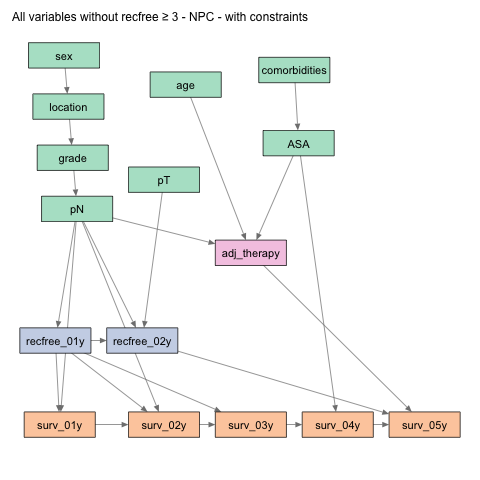

In [74]:
%%R -i adj_matrix,variables
filename.prefix = "hugin - "
algo = "NPC"

net <- BN()
bnstruct::variables(net) <- as.vector(variables)
bnstruct::dag(net) <- data.matrix(adj_matrix)

title.variables <- "All variables without recfree ≥ 3"
non.empty.layering <- c(1, 2, 3)
title <- create.title(title.variables, algo, non.empty.layering)

# Save plot to PDF
filename <- paste(filename.prefix, title, ".pdf", sep="")

plot.network(net, positions, title, filename, "results/adj_vs_none/")
plot.network(net, positions, title)

In [75]:
# We'll use thomas to parse the OOBN
filename = "results/adj_vs_none/colonca_2005_2012_adjuvant_none_simplified.oobn"
variables, adj_matrix = oobn_to_adjacency_matrix(filename)

Saving plot to results/adj_vs_none//hugin - Simplified - NPC - with constraints.pdf 


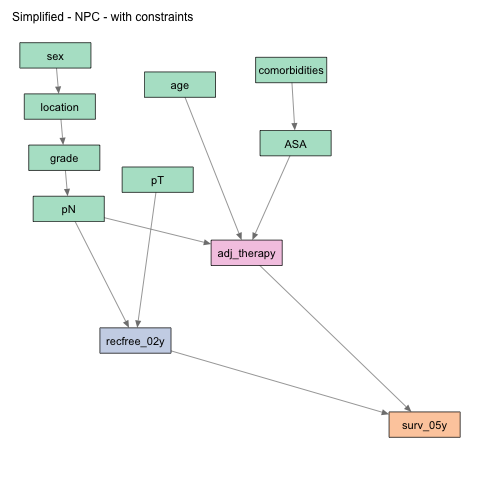

In [76]:
%%R -i adj_matrix,variables
filename.prefix = "hugin - "
algo = "NPC"

net <- BN()
bnstruct::variables(net) <- as.vector(variables)
bnstruct::dag(net) <- data.matrix(adj_matrix)

title.variables <- "Simplified"
non.empty.layering <- c(1, 2, 3)
title <- create.title(title.variables, algo, non.empty.layering)

# Save plot to PDF
filename <- paste(filename.prefix, title, ".pdf", sep="")

plot.network(net, positions, title, filename, "results/adj_vs_none/")
plot.network(net, positions, title)

The above is the result of using a minimal whitelist (consisting of a single edge: ASA → surv_04y).

<div class="alert alert-info">
    If this network is assumed to be correct, the confounders we should correct for are:
    <ul>
        <li>ASA</li>
        <li>pN</li>
    </ul>
</div>

## ⚙️ Structure Learning (bnstruct)

Create dataframes to use in R. 

In [77]:
# We're doing adjuvant vs none, so we'll drop adj_therapy_type
try:
    # Re-running this part of the notebook *after* propensity scores have been
    # calculated, messes up things in R.
    df_adjuvant_none = df_adjuvant_none.drop(columns=['TxQ_bool'])
except:
    
    pass

df_coded, cardinalities = cats_to_codes(df_adjuvant_none)

df_cardinality = pd.DataFrame(
    {
        # "variable": df_coded.columns, 
        "cardinality": cardinalities
    }, 
    index = df_coded.columns
)

df_cardinality.head()

cardinality
sex                      2
age                      3
comorbidities            4
ASA                      5
pT                       4

>>> All variables without recfree ≥ 3 16 mmhc 
Created dataset ... 
Using title: All variables without recfree ≥ 3 - mmhc - with constraints 
Learning network ... [DONE] 
Plotting ... 
Saving plot to results/adj_vs_none/bnstruct/bnstruct - All variables without recfree ≥ 3 - mmhc - with constraints.pdf 
Saving plot to results/adj_vs_none/bnstruct/bnstruct - All variables without recfree ≥ 3 - mmhc - with constraints.png 
 
>>> All variables without recfree ≥ 3 16 SM 
Created dataset ... 
Using title: All variables without recfree ≥ 3 - SM - with constraints 
Learning network ... [DONE] 
Plotting ... 
Saving plot to results/adj_vs_none/bnstruct/bnstruct - All variables without recfree ≥ 3 - SM - with constraints.pdf 
Saving plot to results/adj_vs_none/bnstruct/bnstruct - All variables without recfree ≥ 3 - SM - with constraints.png 
 
>>> Simplified 11 mmhc 
Created dataset ... 
Using title: Simplified - mmhc - with constraints 
Learning network ... [DONE] 
Plotting ... 
Saving plot to 

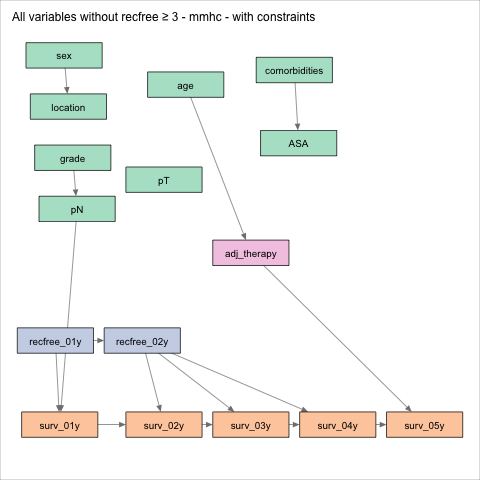

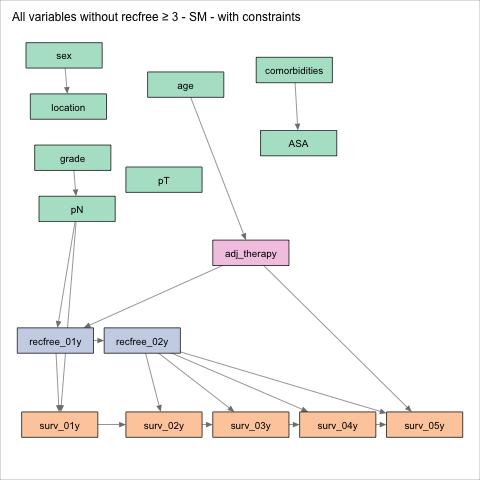

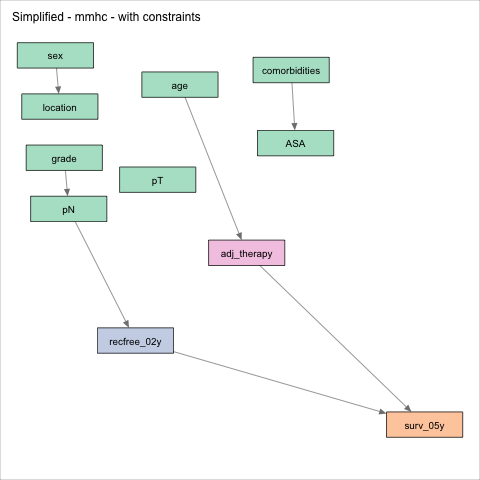

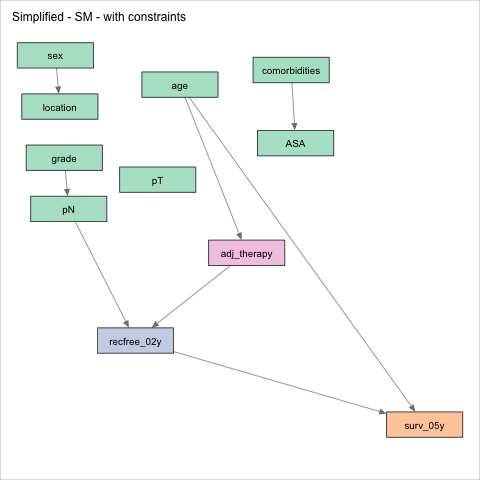

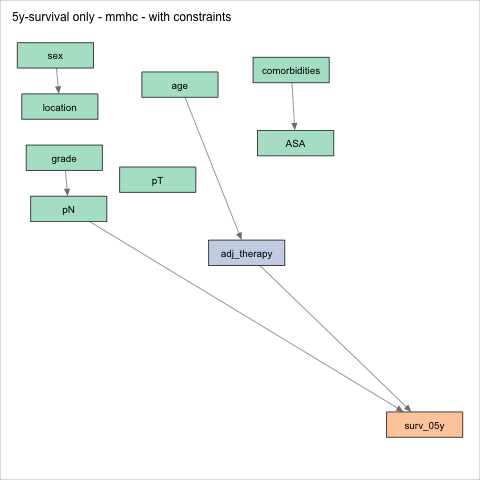

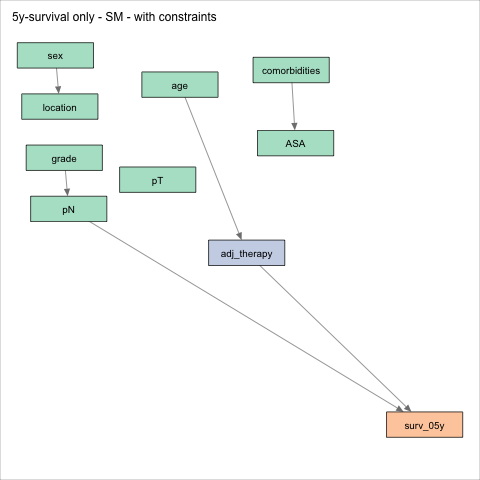

In [78]:
%%R -i df_coded,df_cardinality,layers_array

do.structure.learning = TRUE

if (do.structure.learning) {
    save.image("workspace - adjuvant vs none.RData")

    # Algorithms to include
    algorithms <- c("mmhc", "SM") # "sem" goes against the blacklist 😡.

    # Define node sets
    nodes.all <- colnames(df_coded)
    nodes.without.recfree_gte3 <- nodes.all[!nodes.all %in% c("recfree_03y", "recfree_04y", "recfree_05y")]
    nodes.without.recfree_gte4 <- nodes.all[!nodes.all %in% c("recfree_04y", "recfree_05y")]
    nodes.without.RFS <- nodes.all[!nodes.all %in% c("recfree_01y", "recfree_02y", "recfree_03y", "recfree_04y", "recfree_05y")]
    nodes.simplified <- nodes.all[!nodes.all %in% c("recfree_01y", "recfree_03y", "recfree_04y", "recfree_05y", "surv_01y", "surv_02y", "surv_03y", "surv_04y")]
    nodes.without.conditional.survival <- nodes.all[!nodes.all %in% c(
        "surv_01y", "surv_02y", "surv_03y", "surv_04y", 
        "recfree_01y", "recfree_03y", "recfree_04y", "recfree_05y"
    )]

    nodes.surv_05y.only <- nodes.all[!nodes.all %in% c(
        "recfree_01y", "recfree_02y", "recfree_03y", "recfree_04y", "recfree_05y",
        "surv_01y", "surv_02y", "surv_03y", "surv_04y"
    )]


    # Select sets to include.
    node.sets <- list(
        # "All variables" = nodes.all,
        # "All variables without recfree ≥ 4" = nodes.without.recfree_gte4,
        # "Without conditional survival" = nodes.without.conditional.survival,
        "All variables without recfree ≥ 3" = nodes.without.recfree_gte3,
        "Simplified" = nodes.simplified,
        "5y-survival only" = nodes.surv_05y.only
    )

    # Variable to store output
    networks <- list()

    # Iterate node set ... 
    for (var.set in names(node.sets)) {
        title.variables <- var.set
        variables <- node.sets[[var.set]]

        constraints <- list(
            # c(), 
            create.layer.mapping(variables, layers_array)$idx
        )

        # Iterate over possible sets of constraints ...
        for (layers in constraints) {

            # Iterate over possible algorithms ...
            for (algo in algorithms) {

                title <- paste(title.variables, length(layers), algo)
                writeln(paste(">>>", title))

                net <- run.learn.network(
                    df_coded, 
                    variables, 
                    df_cardinality,
                    layering = layers,
                    algo = algo,
                    title.variables = title.variables,
                    positions = positions,
                    save.path = c("results", "adj_vs_none", "bnstruct"),
                    save.plot = T,
                )

                networks[[title]] <- net
                writeln('')
            }        
        }
    }

}




In [79]:
# %%R 
# nodes.all <- colnames(df_coded)
# create.layer.mapping(nodes.all, layers_array)


# for (l in layers_array) {
#     writeln(l, collapse=', ')
# }
# layers_array

<div class="alert alert-info">
    Results differ depending on the nodes included.
    <ul>
        <li>Therapy and pN have no backdoor(s) between them in any of the networks.</li>
        <li>Therapy and ASA have no backdoor(s) between them in any of the networks.</li>
        <li>Age acts as a confounder in the simplest network that includes one RFS node.</li>
    </ul>
</div>

## Intermediate conclusion

Depending on the nodes included in the analysis, different confounders are identified. The total (union) set consists of:
* pN
* ASA
* age

This seems like a reasonable set.

##  ⚙️ Cox Models ...

### Propensity scores 
We'll use logistic regression to calculate propensity scores. The variables included (as covariates) are based on the Chi&#x00B2; analyses above:
* sex
* **age**
* comorbidities
* **ASA**
* **pN**

Notably the BN only identified `pN` and `ASA` from this list, although it should be noted that yod was excluded from the BN (since the relationships found between yod and RFS were mostly due to insufficient follow-up/NAs).

In [80]:
# Prepare variables to use
outcome = df_adjuvant_none.adj_therapy == 'Yes'
potential_confounders = [
    'sex',
    'age',
    'comorbidities',
    'ASA',
    'pN'
]
covariables = df_adjuvant_none[potential_confounders]

# Calculate propensities
propensities = compute_propensity_scores(covariables, outcome)

# Add propensity score to dataframe.
df_adjuvant_none['TxQ_bool'] = propensities['quantile']
df['TxQ_bool'] = propensities['quantile']
adjustment = 0

In [81]:
# Add the p-values and significance meter from the Chi2 Adjuvant vs None to the
# table containing the Chi2 results from None vs CapMono vs CAPOX
t1_final_stage1 = t1_adj_any_sign.copy()

# Calculate the CMH Chi2 for each of the variables
outcome = 'adj_therapy'

# Names for the columns with p-value and significance meter.
cmh_pname = 'p (CMH)'
cmh_signame = 'sign. (CMH)'

# List to hold intermediate results
results = []

# We're using the same variables as earlier
vars_to_tabulate = list(t1_final_stage1.index.get_level_values(0).drop_duplicates())

for var in vars_to_tabulate:
    print(f'Processing {var}')
    
    try:
        cmh_result = CMH(df_adjuvant_none, var, outcome, stratifier='TxQ_bool', adjustment=adjustment)        
        results.append([var, outcome, cmh_result.p])
        
    except Exception as e:
        print(f'  ⚠️ ERROR: {e}')

cmh_summary = pd.DataFrame(results, columns=['var1', 'var2', cmh_pname])
cmh_summary = tools.add_significance_meter(
    cmh_summary, 
    pcol=cmh_pname, 
    p_precision=p_precision,
    colname=cmh_signame, 
)


# Massage the CMH summary table so it can be joined to t1. 
t2 = cmh_summary.set_index('var1')
t2.index.name = 'variable'

# Extract the relevant columns and make sure the column index matches 
# (which is a multiindex in t1_final)
p_cmh = t2[[cmh_pname, cmh_signame]]
p_cmh.columns = pd.MultiIndex.from_tuples([
    (cmh_pname, ''),
    (cmh_signame, ''),
])

# t1_plus additionally contains the significance stars
t1_final_stage1 = t1_final_stage1.join(p_cmh)

# Clear the CMH p-values for rows that don't have a chi2 p-value.
t1_final_stage1.loc[t1_final_stage1.p == '', (cmh_pname, )] = ''
t1_final_stage1.loc[t1_final_stage1.p == '', (cmh_signame, )] = ''

Processing sex
Processing age
Processing comorbidities
Processing ASA
Processing pT
Processing pN
Processing location
Processing grade


### 🧮 💾 Table 1 - Variable distribution with PS correction

**Display**

In [82]:
# Display the results (with a caption).
tools.table(
    t1_final_stage1, 
    caption="""
        Variable distributions for adjuvant treatment with CAPOX or CapMono. 
        P-value before propenstity score correction calculated using Chi2 test. 
        P-value after propenstity score correction calculated using Cochran-Mantel-Haenzsel (CMH) Chi2 test. 
    """
)

Propensity score was succesful in removing association between all variables and treatment.

**Save**

In [83]:
# Save the result to disk
filename = os.path.join(
    RESULTS_PATH, 
    'Table 1a - variable distributions - adjuvant vs none.xlsx'
)
t1_final_stage1.to_excel(filename)


### Central values & globals

In [84]:
models = {}
predictions = {}
predictions_bool = {}

# Globals
time_col = 'surv_days_post_surg'
event_col = 'deceased'
adj_tx_col = 'adj_therapy'
adj_tx_type_col = 'adj_therapy_type'

# For each column, find the mode, i.e. the most frequently occurring value.
# Note: median cannot be reliably used since 'unknown' is an allowed
#       value for a number of variables.
central_values = df.mode().loc[0].to_dict()
central_values['TxQ_bool'] = 'q3'

### Unadjusted
adjuvant treatment ~ survival

In [85]:
description = 'Unadjusted'

hr_summary, ps = support.create_cox_model_and_predict_survival(
    df, 
    covariables = [], 
    description = description,
    tx_col = 'adj_therapy',
    hr_summary_state = 'Yes'
)

# predictions_bool[(description, '')] = ps

In [86]:
# ps.head()

In [87]:
chart_with_markers(ps, x='survival:Q', y='mean(pct):Q', color='adj_therapy:N')

alt.LayerChart(...)

### Adjusted for pN
treatment + pN ~ OS

In [88]:
description = 'Adjusted for pN'

hr_summary, ps = support.create_cox_model_and_predict_survival(
    df, 
    covariables = ['pN', ], 
    description = description,
    tx_col = 'adj_therapy',
    hr_summary_state = 'Yes',
    hr_summary = hr_summary,
)

In [89]:
# ps.head()
chart_with_markers(ps, x='survival:Q', y='mean(pct):Q', color='adj_therapy:N')

alt.LayerChart(...)

### Adjusted for pN and ASA
treatment + pN + ASA ~ OS

In [90]:
description = 'Adjusted for pN and ASA score'

hr_summary, ps = support.create_cox_model_and_predict_survival(
    df, 
    covariables = ['pN', 'ASA'], 
    description = description,
    tx_col = 'adj_therapy',
    hr_summary_state = 'Yes',
    hr_summary = hr_summary,
)

In [91]:
# ps.head()
chart_with_markers(ps, x='survival:Q', y='mean(pct):Q', color='adj_therapy:N')

alt.LayerChart(...)

### Adjusted for age
treatment + age ~ OS

In [92]:
description = 'Adjusted for age'

hr_summary, ps = support.create_cox_model_and_predict_survival(
    df, 
    covariables = ['age', ], 
    description = description,
    tx_col = 'adj_therapy',
    hr_summary_state = 'Yes',
    hr_summary = hr_summary,
)

In [93]:
# ps.head()
# chart_with_markers(ps, x='survival:Q', y='mean(pct):Q', color='adj_therapy:N')

### Adjusted for age, pN and ASA
treatment + age + pN + ASA ~ OS

In [94]:
description = 'Adjusted for age, pN and ASA score'

hr_summary, ps = support.create_cox_model_and_predict_survival(
    df, 
    covariables = ['age', 'pN', 'ASA'], 
    description = description,
    tx_col = 'adj_therapy',
    additionally_stratify_prediction = ['age'],
    hr_summary_state = 'Yes',
    hr_summary = hr_summary,
)

In [95]:
# ps.head()
# chart_with_markers(ps, x='survival:Q', y='mean(pct):Q', color='adj_therapy:N', column='age:O')

### Adjusted for propensity score
treatment + propensity score ~ OS

In [96]:
description = 'Adjusted for propensity score'

hr_summary, ps = support.create_cox_model_and_predict_survival(
    df, 
    covariables = ['TxQ_bool'], 
    description = description,
    tx_col = 'adj_therapy',
    hr_summary_state = 'Yes',
    hr_summary = hr_summary,
)

In [97]:
# ps.head()
# chart_with_markers(ps, x='survival:Q', y='mean(pct):Q', color='adj_therapy:N')

### Adjusted for everything
treatment + sex + age + comorbidity + ASA score + pT + pN + tumor subsite + differentiation grade + year of diagnosis ~ OS

In [98]:
# description = 'Adjusted for sex, age, comorbidity, ASA score, pT, pN, location, and grade'

# hr_summary, ps = support.create_cox_model_and_predict_survival(
#     df, 
#     covariables = ['sex', 'age', 'comorbidities', 'ASA', 'pT', 'pN', 'location', 'grade'], 
#     description = description,
#     tx_col = 'adj_therapy',
#     additionally_stratify_prediction = ['age'],
#     hr_summary_state = 'Yes',
#     hr_summary = hr_summary,
# )

In [99]:
# ps.head()
# chart_with_markers(ps, x='survival:Q', y='mean(pct):Q', color='adj_therapy:N', column='age:O')

### 🧮 💾 &nbsp; Final table with Hazard Ratios!

**Adding significance asterisks**

In [100]:
# Let's finalize our version of Table 2
HR_treatment = pd.concat(hr_summary.values())

HR_treatment = tools.add_significance_meter(
    HR_treatment, 
    pcol='p', 
    colname='sign.', 
)
HR_treatment.index.name = "Model"

# Save the result to disk
filename = os.path.join(
    RESULTS_PATH, 
    'Table - Hazard Ratios - Adjuvant vs Surgery Only.xlsx'
)
HR_treatment.to_excel(filename)

HR_treatment

HR     95% CI       p sign.
Model                                                            
Unadjusted                          0.41  0.34-0.51  0.0000   ***
Adjusted for pN                     0.36  0.29-0.44  0.0000   ***
Adjusted for pN and ASA score       0.39  0.32-0.49  0.0000   ***
Adjusted for age                    0.46  0.37-0.58  0.0000   ***
Adjusted for age, pN and ASA score  0.44  0.34-0.55  0.0000   ***
Adjusted for propensity score       0.45  0.36-0.58  0.0000   ***

**Visualize the HRs**

In [101]:
data = pd.concat(
    [
        HR_treatment,
        HR_treatment['95% CI'].str.split('-', expand=True)
    ],
    axis=1
).rename(columns={
    '': 'Model',
    0: 'CI_min',
    1: 'CI_max',
})

data.index.name = 'Model'
data = data.reset_index()

In [102]:
sort_order = [
    'Unadjusted',
    'Adjusted for age',
    'Adjusted for pN',
    'Adjusted for pN and ASA score',
    'Adjusted for age, pN and ASA score',
    'Adjusted for sex, age, comorbidity, ASA score, pT, pN, location, grade and YoD',
    'Adjusted for propensity score',
]

# scale = alt.Scale(zero=False)
scale = alt.Scale(domain=(0.2, 0.7))

base = alt.Chart(data).mark_point(
    filled=True,
    size=50,
    color='black'
).encode(
    alt.X('HR:Q', scale=scale),
    alt.Y('Model', sort=sort_order, ),
)

HR_plot = base + base.mark_errorbar().encode(
    alt.X('CI_min:Q', title="Hazard Ratio", scale=scale),
    alt.X2('CI_max:Q'),
).properties(
    title = "Hazard Ratios - Adjuvant vs Surgery Only (reference category)"
)

filename = os.path.join(RESULTS_PATH, 'Figure - Hazard Ratios - Adjuvant vs Surgery Only.pdf')
# HR_plot.save(filename)
HR_plot.save(filename)

HR_plot

alt.LayerChart(...)

# 2️⃣ CAPOX vs CapMono vs None

## 🧮 Table 1 - Variable distribution

In [103]:
include_vars = [
    'sex',
    'age', 
    'comorbidities', 
    'ASA',
    'pT', 
    'pN', 
    'location', 
    'grade', 
    'yod_cat'
]

p_precision=3

df_for_table1 = df.copy()

# Create table1, stratified by adjuvant treatment yes/no.
t1_CAPOX_CapMono_None = tools.stats.table1(
    df_for_table1, 
    include_vars, 
    'adj_therapy_type',
    title='Adjuvant therapy type',
)

# Add asterisks indicating significant association between a variable and treatment.
t1_CAPOX_CapMono_None_sign = tools.add_significance_meter(t1_CAPOX_CapMono_None, p_precision=p_precision)

# Display the results (with a caption).
tools.table(
    t1_CAPOX_CapMono_None_sign, 
    caption='Variable distributions for adjuvant treatment with CAPOX or CapMono vs none. P-value calculated using Chi2 test.'
)

## Structure Learning (Hugin)

## ⚙️ Structure Learning (bnstruct)

Create dataframes to use in R. 

In [139]:
# We're doing adjuvant vs none, so we'll drop adj_therapy_type
df_coded, cardinalities = cats_to_codes(df_simplified.drop(columns=['adj_therapy']))

df_cardinality = pd.DataFrame(
    {
        # "variable": df_coded.columns, 
        "cardinality": cardinalities
    }, 
    index = df_coded.columns
)

df_cardinality.head()

cardinality
sex                      2
age                      3
comorbidities            4
ASA                      5
pT                       4

>>> All variables without recfree ≥ 3 16 mmhc 
Created dataset ... 
Using title: All variables without recfree ≥ 3 - mmhc - with constraints 
Learning network ... [DONE] 
Plotting ... 
Saving plot to results/capox_vs_capmono_vs_none/bnstruct/bnstruct - All variables without recfree ≥ 3 - mmhc - with constraints.pdf 
Saving plot to results/capox_vs_capmono_vs_none/bnstruct/bnstruct - All variables without recfree ≥ 3 - mmhc - with constraints.png 
 
>>> All variables without recfree ≥ 3 16 SM 
Created dataset ... 
Using title: All variables without recfree ≥ 3 - SM - with constraints 
Learning network ... [DONE] 
Plotting ... 
Saving plot to results/capox_vs_capmono_vs_none/bnstruct/bnstruct - All variables without recfree ≥ 3 - SM - with constraints.pdf 
Saving plot to results/capox_vs_capmono_vs_none/bnstruct/bnstruct - All variables without recfree ≥ 3 - SM - with constraints.png 
 
>>> Simplified 11 mmhc 
Created dataset ... 
Using title: Simplified - mmhc - with constraints 
Learni

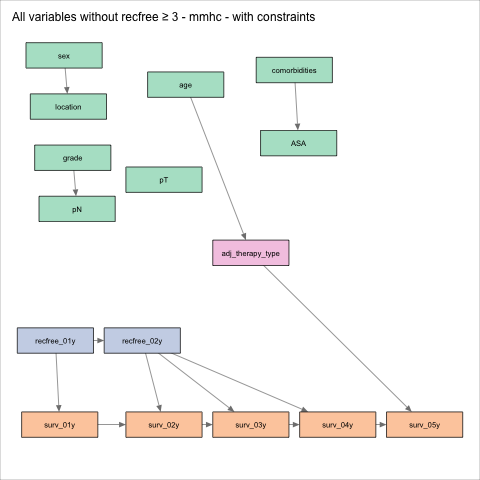

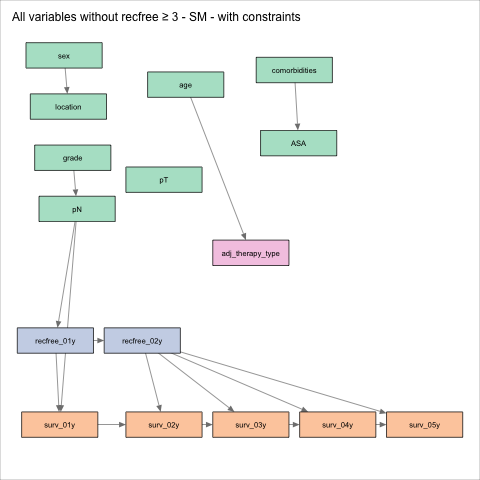

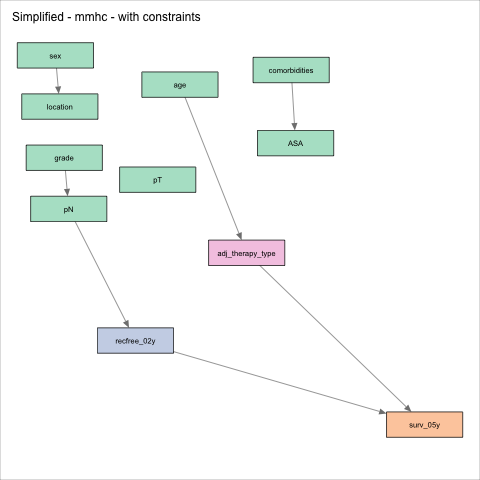

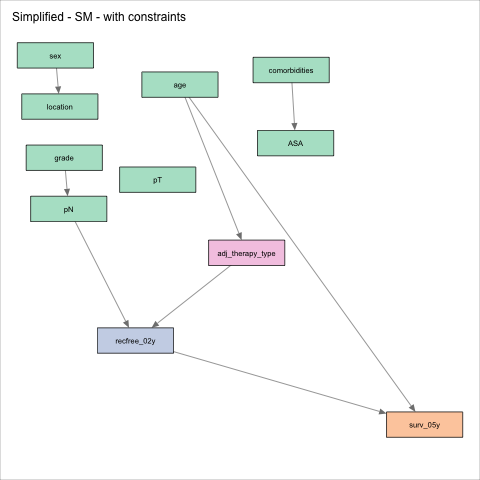

In [140]:
%%R -i df_coded,df_cardinality,layers_array

if (do.structure.learning) {
    save.image("workspace - CAPOX vs CapMono vs None.RData")

    # Algorithms to include
    algorithms <- c("mmhc", "SM") # "sem" goes against the blacklist 😡.

    # Define node sets
    nodes.all <- colnames(df_coded)
    nodes.without.recfree_gte3 <- nodes.all[!nodes.all %in% c("recfree_03y", "recfree_04y", "recfree_05y")]
    nodes.without.recfree_gte4 <- nodes.all[!nodes.all %in% c("recfree_04y", "recfree_05y")]
    nodes.without.RFS <- nodes.all[!nodes.all %in% c("recfree_01y", "recfree_02y", "recfree_03y", "recfree_04y", "recfree_05y")]
    nodes.simplified <- nodes.all[!nodes.all %in% c("recfree_01y", "recfree_03y", "recfree_04y", "recfree_05y", "surv_01y", "surv_02y", "surv_03y", "surv_04y")]
    nodes.without.conditional.survival <- nodes.all[!nodes.all %in% c(
        "surv_01y", "surv_02y", "surv_03y", "surv_04y", 
        "recfree_01y", "recfree_03y", "recfree_04y", "recfree_05y"
    )]

    # Select sets to include.
    node.sets <- list(
        # "All variables" = nodes.all,
        # "All variables without recfree ≥ 4" = nodes.without.recfree_gte4,
        # "Without conditional survival" = nodes.without.conditional.survival,
        "All variables without recfree ≥ 3" = nodes.without.recfree_gte3,
        "Simplified" = nodes.simplified
    )

    # Variable to store output
    networks <- list()

    # Iterate node set ... 
    for (var.set in names(node.sets)) {
        title.variables <- var.set
        variables <- node.sets[[var.set]]

        constraints <- list(
            # c(), 
            create.layer.mapping(variables, layers_array)$idx
        )

        # Iterate over possible sets of constraints ...
        for (layers in constraints) {

            # Iterate over possible algorithms ...
            for (algo in algorithms) {

                title <- paste(title.variables, length(layers), algo)
                writeln(paste(">>>", title))

                net <- run.learn.network(
                    df_coded, 
                    variables, 
                    df_cardinality,
                    layering = layers,
                    algo = algo,
                    title.variables = title.variables,
                    positions = positions,
                    save.path = c("results", "capox_vs_capmono_vs_none", "bnstruct"),
                    save.plot = T,
                )

                networks[[title]] <- net
                writeln('')
            }        
        }
    }
}


<div class="alert alert-info">
    No associations found anymore between treatment and survival. Looks like splitting by adjuvant therapy type reduces the algorithms power.
</div>

## Intermediate conclusion


Didn't run structure learning in Hugin, but am also not really interested in the results.

# 3️⃣ CAPOX vs CapMono

## 🧮 Table 1 - Variable distribution

In [106]:
include_vars = [
    'sex',
    'age', 
    'comorbidities', 
    'ASA',
    'pT', 
    'pN', 
    'location', 
    'grade', 
]

p_precision=3

df_for_table1 = df_adj.copy()

# Create table1, stratified by adjuvant treatment yes/no.
t1_CAPOX_CapMono = tools.stats.table1(
    df_for_table1, 
    include_vars, 
    'adj_therapy_type',
    title='Adjuvant therapy type',
)

# Add asterisks indicating significant association between a variable and treatment.
t1_CAPOX_CapMono_sign = tools.add_significance_meter(t1_CAPOX_CapMono, p_precision=p_precision)

# Display the results (with a caption).
tools.table(
    t1_CAPOX_CapMono_sign, 
    caption='Variable distributions for adjuvant treatment with CAPOX or CapMono vs none. P-value calculated using Chi2 test.'
)

## Structure Learning (Hugin)

In [107]:
# We'll use thomas to parse the OOBN
filename = "results/capox_vs_capmono/colonca_2005_2012_CAPOX_CapMono.oobn"
variables, adj_matrix = oobn_to_adjacency_matrix(filename)


Saving plot to results/capox_vs_capmono//hugin - All variables without recfree ≥ 3 - NPC - with constraints.pdf 


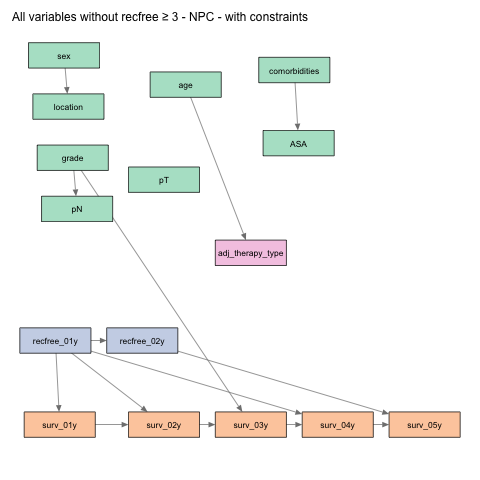

In [108]:
%%R -i adj_matrix,variables
filename.prefix = "hugin - "
algo = "NPC"

net <- BN()
bnstruct::variables(net) <- as.vector(variables)
bnstruct::dag(net) <- data.matrix(adj_matrix)

title.variables <- "All variables without recfree ≥ 3"
non.empty.layering <- c(1, 2, 3)
title <- create.title(title.variables, algo, non.empty.layering)

# Save plot to PDF
filename <- paste(filename.prefix, title, ".pdf", sep="")

plot.network(net, positions, title, filename, "results/capox_vs_capmono/")
plot.network(net, positions, title)

In [109]:
# We'll use thomas to parse the OOBN
filename = "results/capox_vs_capmono/colonca_2005_2012_CAPOX_CapMono_simplified.oobn"
variables, adj_matrix = oobn_to_adjacency_matrix(filename)


Saving plot to results/capox_vs_capmono//hugin - Simplified - NPC - with constraints.pdf 


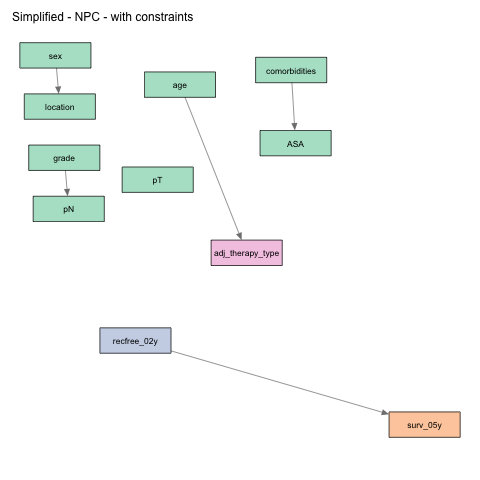

In [110]:
%%R -i adj_matrix,variables
filename.prefix = "hugin - "
algo = "NPC"

net <- BN()
bnstruct::variables(net) <- as.vector(variables)
bnstruct::dag(net) <- data.matrix(adj_matrix)

title.variables <- "Simplified"
non.empty.layering <- c(1, 2, 3)
title <- create.title(title.variables, algo, non.empty.layering)

# Save plot to PDF
filename <- paste(filename.prefix, title, ".pdf", sep="")

plot.network(net, positions, title, filename, "results/capox_vs_capmono/")
plot.network(net, positions, title)

<div class="alert alert-info">
    If this network is assumed to be correct, addition of oxaliplatin has no effect on survival.
</div>

## ⚙️ Structure Learning (bnstruct)

Create dataframes to use in R. 

In [137]:
# We're doing adjuvant vs none, so we'll drop adj_therapy_type
df_coded, cardinalities = cats_to_codes(df_CAPOX_CapMono)

df_cardinality = pd.DataFrame(
    {
        # "variable": df_coded.columns, 
        "cardinality": cardinalities
    }, 
    index = df_coded.columns
)

df_cardinality.head()

cardinality
sex                      2
age                      3
comorbidities            4
ASA                      5
pT                       4

>>> All variables without recfree ≥ 3 16 mmhc 
Created dataset ... 
Using title: All variables without recfree ≥ 3 - mmhc - with constraints 
Learning network ... [DONE] 
Plotting ... 
Saving plot to results/capox_vs_capmono/bnstruct/bnstruct - All variables without recfree ≥ 3 - mmhc - with constraints.pdf 
Saving plot to results/capox_vs_capmono/bnstruct/bnstruct - All variables without recfree ≥ 3 - mmhc - with constraints.png 
 
>>> All variables without recfree ≥ 3 16 SM 
Created dataset ... 
Using title: All variables without recfree ≥ 3 - SM - with constraints 
Learning network ... [DONE] 
Plotting ... 
Saving plot to results/capox_vs_capmono/bnstruct/bnstruct - All variables without recfree ≥ 3 - SM - with constraints.pdf 
Saving plot to results/capox_vs_capmono/bnstruct/bnstruct - All variables without recfree ≥ 3 - SM - with constraints.png 
 
>>> Simplified 11 mmhc 
Created dataset ... 
Using title: Simplified - mmhc - with constraints 
Learning network ... [DONE] 
Plotting 

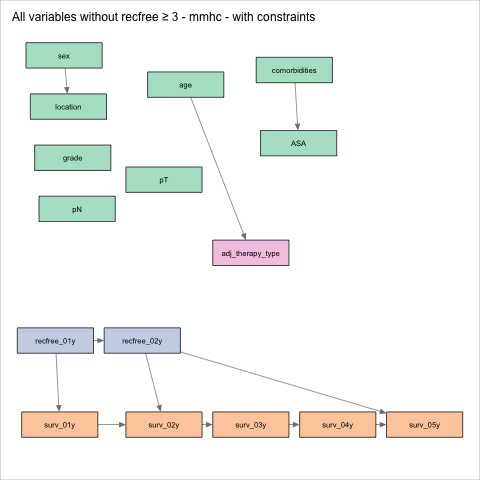

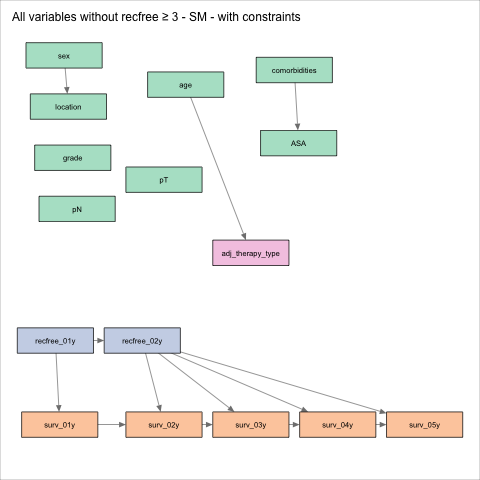

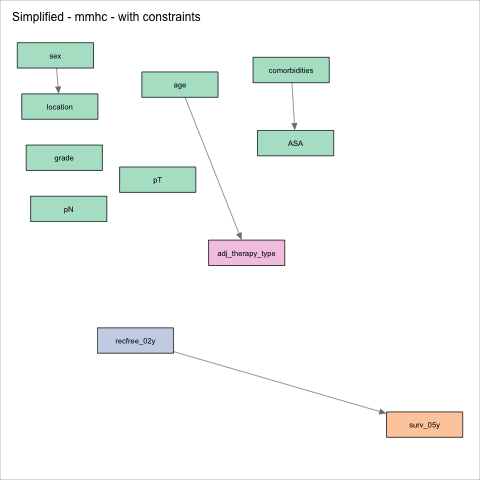

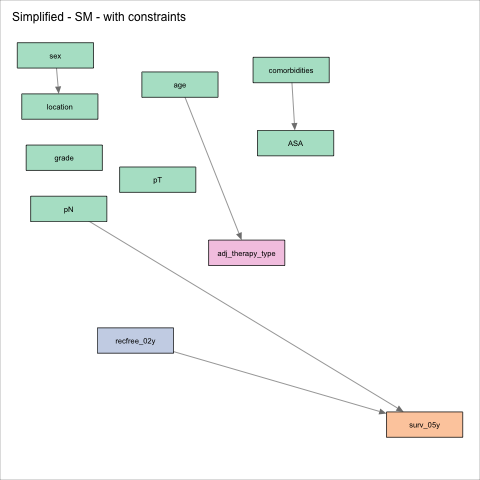

In [138]:
%%R -i df_coded,df_cardinality,layers_array


if (do.structure.learning) {
    save.image("workspace - CAPOX vs CapMono.RData")

    # Algorithms to include
    algorithms <- c("mmhc", "SM") # "sem" goes against the blacklist 😡.

    # Define node sets
    nodes.all <- colnames(df_coded)
    nodes.without.recfree_gte3 <- nodes.all[!nodes.all %in% c("recfree_03y", "recfree_04y", "recfree_05y")]
    nodes.without.recfree_gte4 <- nodes.all[!nodes.all %in% c("recfree_04y", "recfree_05y")]
    nodes.without.RFS <- nodes.all[!nodes.all %in% c("recfree_01y", "recfree_02y", "recfree_03y", "recfree_04y", "recfree_05y")]
    nodes.simplified <- nodes.all[!nodes.all %in% c("recfree_01y", "recfree_03y", "recfree_04y", "recfree_05y", "surv_01y", "surv_02y", "surv_03y", "surv_04y")]
    nodes.without.conditional.survival <- nodes.all[!nodes.all %in% c(
        "surv_01y", "surv_02y", "surv_03y", "surv_04y", 
        "recfree_01y", "recfree_03y", "recfree_04y", "recfree_05y"
    )]

    # Select sets to include.
    node.sets <- list(
        # "All variables" = nodes.all,
        # "All variables without recfree ≥ 4" = nodes.without.recfree_gte4,
        # "Without conditional survival" = nodes.without.conditional.survival,
        "All variables without recfree ≥ 3" = nodes.without.recfree_gte3,
        "Simplified" = nodes.simplified
    )

    # Variable to store output
    networks <- list()

    # Iterate node set ... 
    for (var.set in names(node.sets)) {
        title.variables <- var.set
        variables <- node.sets[[var.set]]

        constraints <- list(
            # c(), 
            create.layer.mapping(variables, layers_array)$idx
        )

        # Iterate over possible sets of constraints ...
        for (layers in constraints) {

            # Iterate over possible algorithms ...
            for (algo in algorithms) {

                title <- paste(title.variables, length(layers), algo)
                writeln(paste(">>>", title))

                net <- run.learn.network(
                    df_coded, 
                    variables, 
                    df_cardinality,
                    layering = layers,
                    algo = algo,
                    title.variables = title.variables,
                    positions = positions,
                    save.path = c("results", "capox_vs_capmono", "bnstruct"),
                    save.plot = T,
                )

                networks[[title]] <- net
                writeln('')
            }        
        }
    }
}


## Intermediate conclusion


When looking at patients that received adjuvant therapy _only_, MMHC/SM find no association between adding oxaliplatin and survival.

## ⚙️ Cox Models ...

### Propensity scores 
We'll use logistic regression to calculate propensity scores. The variables included (as covariates) are based on the Chi&#x00B2; analyses above:
* age
* comorbidities

Notably the BN did not find any confounders (or associations with treatment, for that matter).

In [113]:
# Prepare variables to use
outcome = df_adj.adj_therapy_type == 'CAPOX'
potential_confounders = [
    'age',
    'comorbidities',
]
covariables = df_adj[potential_confounders]

# Calcu_adjlate propensities
propensities = compute_propensity_scores(covariables, outcome)

# Add propensity score to dataframe.
df_adj['TxQ_bool'] = propensities['quantile']

adjustment = 0.1

In [114]:
# Add the p-values and significance meter from the Chi2 Adjuvant vs None to the
# table containing the Chi2 results from None vs CapMono vs CAPOX
t1_final_stage1 = t1_CAPOX_CapMono_sign.copy()

# Calculate the CMH Chi2 for each of the variables
outcome = 'adj_therapy_type'

# Names for the columns with p-value and significance meter.
cmh_pname = 'p (CMH)'
cmh_signame = 'sign. (CMH)'

# List to hold intermediate results
results = []

# We're using the same variables as earlier
vars_to_tabulate = list(t1_final_stage1.index.get_level_values(0).drop_duplicates())

for var in vars_to_tabulate:
    print(f'Processing {var}')
    
    try:
        cmh_result = CMH(df_adj, var, outcome, stratifier='TxQ_bool', adjustment=adjustment)        
        results.append([var, outcome, cmh_result.p])
        
    except Exception as e:
        print(f'  ⚠️ ERROR: {e}')

cmh_summary = pd.DataFrame(results, columns=['var1', 'var2', cmh_pname])
cmh_summary = tools.add_significance_meter(
    cmh_summary, 
    pcol=cmh_pname, 
    p_precision=p_precision,
    colname=cmh_signame, 
)


# Massage the CMH summary table so it can be joined to t1. 
t2 = cmh_summary.set_index('var1')
t2.index.name = 'variable'

# Extract the relevant columns and make sure the column index matches 
# (which is a multiindex in t1_final)
p_cmh = t2[[cmh_pname, cmh_signame]]
p_cmh.columns = pd.MultiIndex.from_tuples([
    (cmh_pname, ''),
    (cmh_signame, ''),
])

# t1_plus additionally contains the significance stars
t1_final_stage1 = t1_final_stage1.join(p_cmh)

# Clear the CMH p-values for rows that don't have a chi2 p-value.
t1_final_stage1.loc[t1_final_stage1.p == '', (cmh_pname, )] = ''
t1_final_stage1.loc[t1_final_stage1.p == '', (cmh_signame, )] = ''

Processing sex
Processing age
Processing comorbidities
Processing ASA
Processing pT
Processing pN
Processing location
Processing grade


### 🧮 💾 Table 1 - Variable distribution with PS correction

**Display**

In [115]:
# Display the results (with a caption).
tools.table(
    t1_final_stage1, 
    caption="""
        Variable distributions for adjuvant treatment with CAPOX vs CapMono. 
        P-value before propenstity score correction calculated using Chi2 test. 
        P-value after propenstity score correction calculated using Cochran-Mantel-Haenzsel (CMH) Chi2 test. 
    """
)

**Save**

In [116]:
# Save the result to disk
filename = os.path.join(
    RESULTS_PATH, 
    'Table 1b - variable distributions - CAPOX vs CapMono.xlsx'
)
t1_final_stage1.to_excel(filename)


### Unadjusted
adjuvant treatment ~ survival

In [141]:
description = 'Unadjusted'

hr_summary, ps = support.create_cox_model_and_predict_survival(
    df_adj, 
    covariables = [], 
    description = description,
    tx_col = 'adj_therapy_type',
    hr_summary_state = 'CAPOX',
    penalizer = 0.1,
    nyear = 10
)

# predictions_bool[(description, '')] = ps

In [142]:
# hr_summary[description]

In [143]:
chart_with_markers(ps, x='survival:Q', y='mean(pct):Q', color='adj_therapy_type:N').properties(
    width = 440
)

alt.LayerChart(...)

### Adjusted for age
treatment + age ~ OS

In [144]:
description = 'Adjusted for age'

# hr_summary, ps = support.create_cox_model_and_predict_survival(
#     df_adj, 
#     covariables = ['age'], 
#     description = description,
#     tx_col = 'adj_therapy_type',
#     hr_summary_state = 'CAPOX',
#     hr_summary = hr_summary,
#     penalizer = 0.1,
# )

In [145]:
# ps.head()

In [146]:
chart_with_markers(ps, x='survival:Q', y='mean(pct):Q', color='adj_therapy_type:N').properties(
    width = 440
)

alt.LayerChart(...)

### Adjusted for propensity score
treatment + propensity score ~ OS

In [147]:
description = 'Adjusted for propensity score'

hr_summary, ps = support.create_cox_model_and_predict_survival(
    df_adj, 
    covariables = ['TxQ_bool'], 
    description = description,
    tx_col = 'adj_therapy_type',
    hr_summary_state = 'CAPOX',
    hr_summary = hr_summary,
    penalizer = 0.1,
)

In [148]:
# ps.head()
# chart_with_markers(ps, x='survival:Q', y='mean(pct):Q', color='adj_therapy:N')

### 🧮 💾 &nbsp; Final table with Hazard Ratios!

**Adding significance asterisks**

In [149]:
# Let's finalize our version of Table 2
HR_adj_type = pd.concat(hr_summary.values())

HR_adj_type = tools.add_significance_meter(
    HR_adj_type, 
    pcol='p', 
    colname='sign.', 
)

HR_adj_type.index.name = "Model"

# Save the result to disk
filename = os.path.join(
    RESULTS_PATH, 
    'Table - Hazard Ratios - CAPOX vs CapMono.xlsx'
)
HR_adj_type.to_excel(filename)


HR_adj_type

HR     95% CI       p sign.
Model                                                       
Unadjusted                     0.93  0.68-1.28  0.6669      
Adjusted for propensity score  0.94  0.68-1.31  0.7274

**Visualize the HRs**

In [150]:
data = pd.concat(
    [
        HR_adj_type,
        HR_adj_type['95% CI'].str.split('-', expand=True)
    ],
    axis=1
).rename(columns={
    '': 'Model',
    0: 'CI_min',
    1: 'CI_max',
})

data.index.name = 'Model'
data = data.reset_index()

In [151]:
sort_order = [
    'Unadjusted',
    'Adjusted for age',
    'Adjusted for propensity score',
]

# scale = alt.Scale(zero=False)
scale = alt.Scale(domain=(0.5, 2))

base = alt.Chart(data).mark_point(
    filled=True,
    size=50,
    color='black'
).encode(
    alt.X('HR:Q', scale=scale),
    alt.Y('Model', sort=sort_order, ),
)

HR_plot = base + base.mark_errorbar().encode(
    alt.X('CI_min:Q', title="Hazard Ratio", scale=scale),
    alt.X2('CI_max:Q'),
).properties(
    title = "Hazard Ratios - CAPOX vs CapMono (reference category)"
)

filename = os.path.join(RESULTS_PATH, 'Figure - Hazard Ratios - CAPOX vs CapMono.pdf')
HR_plot.save(filename)

HR_plot

alt.LayerChart(...)

# Table 1 - full

## Counts & percentages

In [152]:
include_vars = [
    'sex',
    'age', 
    'comorbidities', 
    'ASA',
    'pT', 
    'pN', 
    'location', 
    'grade', 
    # 'yod_cat'
]

p_precision = 3

# Create table1, stratified by adjuvant treatment regimen and 
# drop the column with significance values.
t1_CAPOX_CapMono_None = support.table1(
    df, 
    include_vars, 
    'adj_therapy_type',
    title='Adjuvant therapy type',
).drop(columns=[('Adjuvant therapy type', 'p')])

t1_CAPOX_CapMono_None.head()

Adjuvant therapy type                       
                                  None    CapMono       CAPOX
variable values                                              
sex      male               284 (45.1)  75 (46.6)  108 (56.5)
         female             346 (54.9)  86 (53.4)   83 (43.5)
age      70 - 74            108 (17.1)  52 (32.3)  140 (73.3)
         75 - 79            197 (31.3)  84 (52.2)   47 (24.6)
         80+                325 (51.6)  25 (15.5)     4 (2.1)

## Adjuvant vs None - Chi2

In [153]:
title = "Adjuvant therapy vs Surgery Only"
outcome = 'adj_therapy'

t1_adj_None = support.table1(
    df, 
    include_vars, 
    outcome,
    title = title,
)

t1_adj_None = tools.add_significance_meter(
    t1_adj_None,
    pcol = (title, 'p'),
    colname = (title, 'sign.'),
    p_precision = p_precision
)

# Drop counts & percentages
cols_to_drop = df[outcome].cat.categories.tolist()
t1_adj_None = t1_adj_None.drop(cols_to_drop, axis=1, level=1)

t1_adj_None.head()

Adjuvant therapy vs Surgery Only      
                                                p sign.
variable values                                        
sex      male                               0.044     *
         female                                        
age      70 - 74                            0.000   ***
         75 - 79                                       
         80+

In [154]:
# Names for the columns with p-value and significance meter.
cmh_pname = 'p (CMH)'
cmh_signame = 'sign. (CMH)'

# List to hold intermediate results
results = []

# We're using the same variables as earlier
vars_to_tabulate = list(t1_adj_None.index.get_level_values(0).drop_duplicates())

for var in vars_to_tabulate:
    # print(f'Processing {var}')    
    try:
        cmh_result = CMH(df_adjuvant_none, var, outcome, stratifier='TxQ_bool', adjustment=adjustment)        
        results.append([var, outcome, cmh_result.p])
        
    except Exception as e:
        print(f'  ⚠️ ERROR:', e)

cmh_summary = pd.DataFrame(results, columns=['var1', 'var2', cmh_pname])
cmh_summary = tools.add_significance_meter(
    cmh_summary, 
    pcol = cmh_pname, 
    p_precision = p_precision,
    colname = cmh_signame, 
)

# Massage the CMH summary table so it can be joined to t1. 
t2 = cmh_summary.set_index('var1')
t2.index.name = 'variable'


# Extract the relevant columns and make sure the column index matches 
# (which is a multiindex in t1_final)
p_cmh = t2[[cmh_pname, cmh_signame]]
p_cmh.columns = pd.MultiIndex.from_tuples([
    (title, cmh_pname),
    (title, cmh_signame),
])

# Add the p-values and significance meter from the Chi2 Adjuvant vs None to the
# table containing the Chi2 results from None vs CapMono vs CAPOX
t1_adj_None_full = t1_adj_None.copy()

t1_adj_None_full = t1_adj_None_full.join(p_cmh)

# Clear the CMH p-values for rows that don't have a chi2 p-value.
t1_adj_None_full.loc[t1_adj_None_full[(title, 'p')] == '', (title, cmh_pname)] = ''
t1_adj_None_full.loc[t1_adj_None_full[(title, 'p')] == '', (title, cmh_signame)] = ''

t1_adj_None_full.head()

Adjuvant therapy vs Surgery Only                          
                                                p sign. p (CMH) sign. (CMH)
variable values                                                            
sex      male                               0.044     *   0.540            
         female                                                            
age      70 - 74                            0.000   ***   0.106            
         75 - 79                                                           
         80+

In [155]:
t1 = t1_CAPOX_CapMono_None.join(t1_adj_None_full)
t1.head()

Adjuvant therapy type                         \
                                  None    CapMono       CAPOX   
variable values                                                 
sex      male               284 (45.1)  75 (46.6)  108 (56.5)   
         female             346 (54.9)  86 (53.4)   83 (43.5)   
age      70 - 74            108 (17.1)  52 (32.3)  140 (73.3)   
         75 - 79            197 (31.3)  84 (52.2)   47 (24.6)   
         80+                325 (51.6)  25 (15.5)     4 (2.1)   

                 Adjuvant therapy vs Surgery Only                            
                                                p sign. p (CMH) sign. (CMH)  
variable values                                                              
sex      male                               0.044     *   0.540              
         female                                                              
age      70 - 74                            0.000   ***   0.106              
         75 - 79                                                             
         80+

## CAPOX vs CAPMONO - Chi2

In [156]:
outcome = 'adj_therapy_type'
title = 'CAPOX vs CapMono'

t1_CAPOX_CapMono = support.table1(
    df_adj, 
    include_vars, 
    outcome,
    title = title,
)

t1_CAPOX_CapMono = tools.add_significance_meter(
    t1_CAPOX_CapMono,
    pcol = (title, 'p'),
    colname = (title, 'sign.'),
    p_precision = p_precision
)

cols_to_drop = df_adj[outcome].cat.categories.tolist()
t1_CAPOX_CapMono = t1_CAPOX_CapMono.drop(cols_to_drop, axis=1, level=1)


t1_CAPOX_CapMono.head()

CAPOX vs CapMono      
                                p sign.
variable values                        
sex      male               0.079      
         female                        
age      70 - 74            0.000   ***
         75 - 79                       
         80+

In [157]:
# Names for the columns with p-value and significance meter.
cmh_pname = 'p (CMH)'
cmh_signame = 'sign. (CMH)'

# List to hold intermediate results
results = []

# We're using the same variables as earlier
vars_to_tabulate = list(t1_adj_None.index.get_level_values(0).drop_duplicates())

for var in vars_to_tabulate:
    # print(f'Processing {var}')    
    try:
        cmh_result = CMH(df_adj, var, outcome, stratifier='TxQ_bool', adjustment=adjustment)        
        results.append([var, outcome, cmh_result.p])
        
    except Exception as e:
        print(f'  ⚠️ ERROR:', e)

cmh_summary = pd.DataFrame(results, columns=['var1', 'var2', cmh_pname])
cmh_summary = tools.add_significance_meter(
    cmh_summary, 
    pcol = cmh_pname, 
    p_precision = p_precision,
    colname = cmh_signame, 
)

# Massage the CMH summary table so it can be joined to t1. 
t2 = cmh_summary.set_index('var1')
t2.index.name = 'variable'


# Extract the relevant columns and make sure the column index matches 
# (which is a multiindex in t1_final)
p_cmh = t2[[cmh_pname, cmh_signame]]
p_cmh.columns = pd.MultiIndex.from_tuples([
    (title, cmh_pname),
    (title, cmh_signame),
])

# Add the p-values and significance meter from the Chi2 Adjuvant vs None to the
# table containing the Chi2 results from None vs CapMono vs CAPOX
t1_CAPOX_CapMono_full = t1_CAPOX_CapMono.copy()

t1_CAPOX_CapMono_full = t1_CAPOX_CapMono_full.join(p_cmh)

# Clear the CMH p-values for rows that don't have a chi2 p-value.
t1_CAPOX_CapMono_full.loc[t1_CAPOX_CapMono_full[(title, 'p')] == '', (title, cmh_pname)] = ''
t1_CAPOX_CapMono_full.loc[t1_CAPOX_CapMono_full[(title, 'p')] == '', (title, cmh_signame)] = ''

t1_CAPOX_CapMono_full.head()

CAPOX vs CapMono                          
                                p sign. p (CMH) sign. (CMH)
variable values                                            
sex      male               0.079         0.094            
         female                                            
age      70 - 74            0.000   ***   0.129            
         75 - 79                                           
         80+

## 💾 Combined

In [158]:
t1 = t1_CAPOX_CapMono_None.join(t1_adj_None_full).join(t1_CAPOX_CapMono_full)

# Save the result to disk
filename = os.path.join(
    RESULTS_PATH, 
    'Table 1 - variable distributions.xlsx'
)
t1.to_excel(filename)

# Display
t1

Adjuvant therapy type                          \
                                             None     CapMono       CAPOX   
variable      values                                                        
sex           male                     284 (45.1)   75 (46.6)  108 (56.5)   
              female                   346 (54.9)   86 (53.4)   83 (43.5)   
age           70 - 74                  108 (17.1)   52 (32.3)  140 (73.3)   
              75 - 79                  197 (31.3)   84 (52.2)   47 (24.6)   
              80+                      325 (51.6)   25 (15.5)     4 (2.1)   
comorbidities none                      97 (15.4)   33 (20.5)   65 (34.0)   
              1                        135 (21.4)   52 (32.3)   48 (25.1)   
              2+                       377 (59.8)   72 (44.7)   74 (38.7)   
              unknown                    21 (3.3)     4 (2.5)     4 (2.1)   
ASA           1                          16 (2.5)    12 (7.5)   25 (13.1)   
              2                        241 (38.3)   83 (51.6)  106 (55.5)   
              3                        220 (34.9)   27 (16.8)   20 (10.5)   
              4                           4 (0.6)     0 (0.0)     1 (0.5)   
              unknown                  149 (23.7)   39 (24.2)   39 (20.4)   
pT            T1                         10 (1.6)     6 (3.7)     4 (2.1)   
              T2                         51 (8.1)   18 (11.2)    18 (9.4)   
              T3                       452 (71.7)  107 (66.5)  144 (75.4)   
              T4                       117 (18.6)   30 (18.6)   25 (13.1)   
pN            N1                       478 (75.9)  107 (66.5)  124 (64.9)   
              N2                       152 (24.1)   54 (33.5)   67 (35.1)   
location      proximal                 393 (62.4)   99 (61.5)   98 (51.3)   
              distal                   230 (36.5)   60 (37.3)   90 (47.1)   
              other/unknown               7 (1.1)     2 (1.2)     3 (1.6)   
grade         g1                         34 (5.4)    10 (6.2)     4 (2.1)   
              g2                       394 (62.5)   95 (59.0)  135 (70.7)   
              g3                       162 (25.7)   41 (25.5)   41 (21.5)   
              g4                          1 (0.2)     1 (0.6)     0 (0.0)   
              unknown                    39 (6.2)    14 (8.7)    11 (5.8)   

                            Adjuvant therapy vs Surgery Only                \
                                                           p sign. p (CMH)   
variable      values                                                         
sex           male                                     0.044     *   0.540   
              female                                                         
age           70 - 74                                  0.000   ***   0.106   
              75 - 79                                                        
              80+                                                            
comorbidities none                                     0.000   ***   0.955   
              1                                                              
              2+                                                             
              unknown                                                        
ASA           1                                        0.000   ***   0.513   
              2                                                              
              3                                                              
              4                                                              
              unknown                                                        
pT            T1                                       0.259         0.157   
              T2                                                             
              T3                                                             
              T4                                                             
pN

# Conclusion

# Finish

In [159]:
notebook_summary = [
    """## Summary of files created""",
    """Below you'll find a list of files that were created/written while running this notebook.""",
    """The cell that creates/displays this summary, can be found <a href="#Finish">here</a>.""",
    *notebook_summary
]
md = Markdown("\n".join(notebook_summary))
summary_cell.update(md)


In [160]:
# Apparently, you can't link to main level anchors (e.g. "#Preeamble")?
display(Markdown("""Go back to the <a href="#Summary-of-files-created">top</a>"""))

Go back to the <a href="#Summary-of-files-created">top</a>